# Dog Breed Classification With a Deep Neural Network

The aim of this project is to classify pictures of dogs depending on their corresponding breed. The data used in this project have been obtained from the Stanford Dogs Dataset available <a href=http://vision.stanford.edu/aditya86/ImageNetDogs/>here</a>. First the data format and distribution have been studied through a rapid EDA. Then the data have been imported in a tensorflow dataset in order to be fed to deep neural networks with high performances. Indeed, such image classifications are often performed using deep neural networks and more specifically convolutional neural networks (<a href=https://en.wikipedia.org/wiki/Convolutional_neural_network>see</a>).

**Illustration of a convolutional neural network**

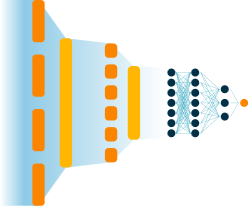

Several technics of image transformation (augmentation, whitening...) have been tested. These technics allow either to exacerbate the features or can reduce the model overfitting by generating some diversity in the dataset.

Then strategies of "Transfer Learning" have been assayed with popular models (<a href=https://keras.io/api/applications/>see</a>). Two methods have been tested : training only the last dense layers or training the first and last dense layers.

Finally, the prediction resulting from the model with the higher performances have been studied in detail in order to better understand the possible flaws of the model.

In [1]:
import os
import requests
import shutil
import tarfile
import numpy as np
import matplotlib.image as mpimg
import re
import time
import glob

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

from PIL import Image

from skimage import exposure, img_as_float, filters
from skimage.util import img_as_ubyte
from skimage.io import imsave

from tensorflow.keras.callbacks import TensorBoard

In [2]:
# Custom colors for charts

c_0 = np.array([2, 48, 71,256])/256
c_1 = np.array([251, 133, 0,256])/256
c_2 = np.array([255, 183, 3,256])/256
c_3 = np.array([33, 158, 188,256])/256
c_4 = np.array([142, 202, 230,256])/256

# Creating a custom colormap
# The code comes from https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
from matplotlib.colors import ListedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(c_0[0], c_1[0], N)
vals[:, 1] = np.linspace(c_0[1], c_1[1], N)
vals[:, 2] = np.linspace(c_0[2], c_1[2], N)
custom_cmp1 = ListedColormap(vals)

# A colormap with white in the middle
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate((np.linspace(c_0[0], 1, 128), np.linspace(1, c_1[0], 128)), axis = None)
vals[:, 1] = np.concatenate((np.linspace(c_0[1], 1, 128), np.linspace(1, c_1[1], 128)), axis = None)
vals[:, 2] = np.concatenate((np.linspace(c_0[2], 1, 128), np.linspace(1, c_1[2], 128)), axis = None)
custom_cmp2 = ListedColormap(vals)

# Allow value-dependant colorbar

def color_bar(y, cmap=custom_cmp1):
    
    # Create the matrix for colors
    color_list = []
    # Normalise the values
    y = (y-min(y))/(max(y)-min(y))
    
    for i in range(len(y)):
        color_list.append(cmap(int(N*y[i])))
    
    return color_list

Limit GPU memory usage. For more info look at : https://www.tensorflow.org/guide/gpu

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
# The random state is fixed
tf.random.set_seed = 42
np.random.seed(42)

# 1. Importing the data

First data should be downloaded.

In [5]:
# We check if the data have allready been downloaded
if not os.path.isfile('raw_data.tar'):
    print('Downloading data...')
    
    # The data are found at the following adress :
    url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
    
    # The file is downloaded in a stream
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open('raw_data.tar', 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    print('Done !')

# Check if data should be extracted
if not os.path.isdir('Images'):
    print('Extracting data...')
    with tarfile.open('raw_data.tar', 'r') as f:
        f.extractall()
    print('Done !')
    

# 2. EDA

## 2.1 Samples distribution

A rapid EDA is performed using paths names in order to get an idea of the number of sample and distribution.

In [6]:
# Breed file names are put in a list
breed_list = os.listdir('Images')

# Dict breed vs picture name is built
picture_dict = {}
for breed in breed_list:
    for picture in os.listdir(f'Images/{breed}'):
        picture_dict[picture] = breed

C:\Users\alfre\AppData\Local\Temp\ipykernel_21812\3845722037.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([breed_name_list[i] for i in np.argsort(n_pic_list)], rotation=90, ha='right', size = 5)


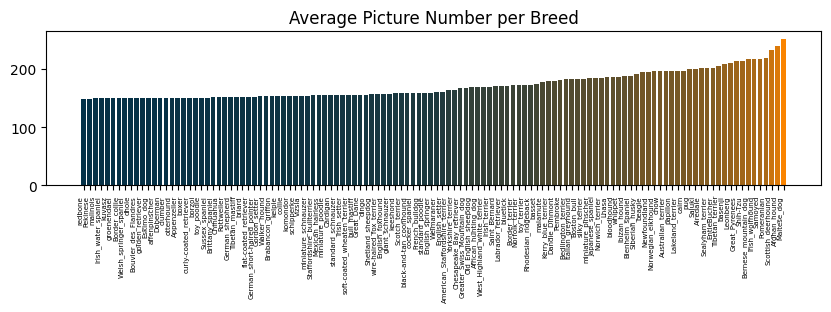

In [7]:
n_pic_list = []
for breed in breed_list:
    n_pic_list.append(len([p for (p, b) in picture_dict.items() if b == breed]))

# For better reading a clean breed list is built
pattern = re.compile(r'n[0-9\-]{9}')
breed_name_list = [pattern.sub('', breed) for breed in breed_list]

fig, ax = plt.subplots(figsize = (10,2))
ax.bar(x = breed_list,
       height = np.sort(n_pic_list),
       color = color_bar(np.array(np.sort(n_pic_list))))

ax.set_xticklabels([breed_name_list[i] for i in np.argsort(n_pic_list)], rotation=90, ha='right', size = 5)
ax.set_title("Average Picture Number per Breed")
plt.show()

In [8]:
print(f'The average picture number is {np.mean(n_pic_list)}')
print(f'The median picture number is {np.median(n_pic_list)}')
print(f'The standard deviation on picture number is {np.std(n_pic_list)}')
print(f'The minimum is {np.min(n_pic_list)}')
print(f'The maximum is {np.max(n_pic_list)}')
print(f'There is {len(picture_dict.keys())} pictures in total')
print(f'for {len(breed_list)} breeds')

The average picture number is 171.5
The median picture number is 159.5
The standard deviation on picture number is 23.123941417212308
The minimum is 148
The maximum is 252
There is 20580 pictures in total
for 120 breeds


## 2.2 Samples dimentions

Few pictures are visualized

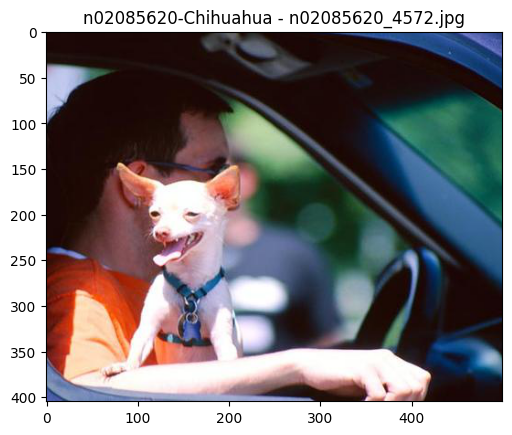

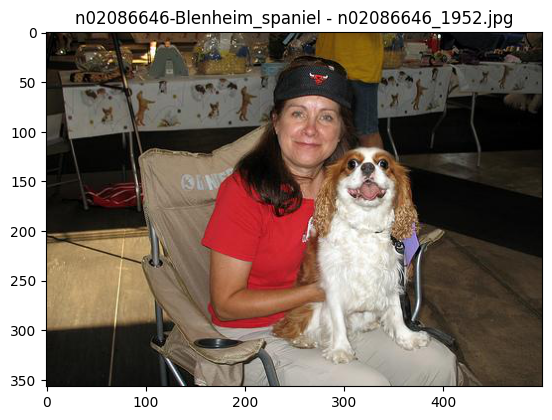

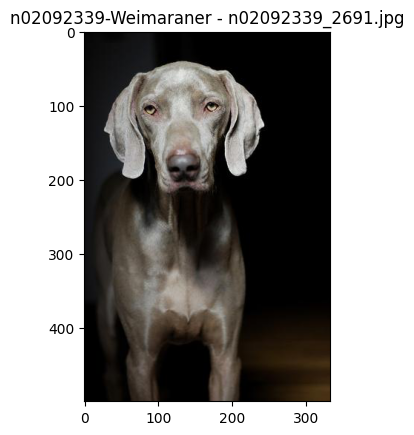

In [9]:
for i in [100,1000,5000]:
    pic_name = list(picture_dict.keys())[i]
    breed = picture_dict[pic_name]
    img = mpimg.imread(f'Images/{breed}/{pic_name}')
    plt.imshow(img)
    plt.title(f'{breed} - {pic_name}')
    plt.show()

The statistics on pictures dimensions are studied:

In [10]:
mean_pic_size_list = []
for breed in breed_list:
    mean_pic_size_list.append(np.mean([mpimg.imread(f'Images/{b}/{p}').size for (p, b) in picture_dict.items() if b == breed]))


C:\Users\alfre\AppData\Local\Temp\ipykernel_21812\1869002051.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([breed_name_list[i] for i in np.argsort(mean_pic_size_list)], rotation=90, ha='right', size = 5)


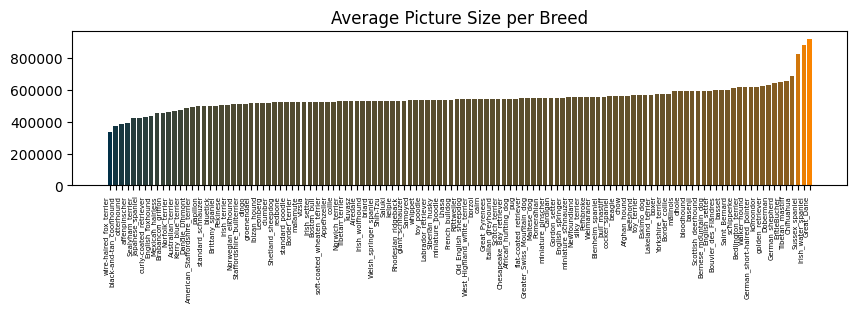

In [11]:
fig, ax = plt.subplots(figsize = (10,2))
ax.bar(x = breed_list,
       height = np.sort(mean_pic_size_list),
       color = color_bar(np.sort(np.array(mean_pic_size_list))))

ax.set_xticklabels([breed_name_list[i] for i in np.argsort(mean_pic_size_list)], rotation=90, ha='right', size = 5)

ax.set_title('Average Picture Size per Breed')
plt.show()

## 2.3 Conclusion on the EDA

We can observe that:
- There is a total of 120 breeds represented in the dataset for a total of 20580 pictures
- Breeds are represented by a different number of pictures (with an average of 171)
- However the number of picture per breed seems balanced with a standard deviation of 23
- Several pictures present complex backgrounds (with objects, vegetation, humans...)
- Breeds are represented with pictures of different sizes
- Some breeds folders contains larger pictures as for the Saint-Bernard or Irish water spaniel

# 3. Data augmentation and preprocessing

Then data are loaded with keras.

Informations about this step can be found in the <a href=https://www.tensorflow.org/tutorials/load_data/images>TensorFlow documentation</a>.

In [6]:
batch_size = 32

# Images are rescaled to 224x224 (as in VGG16)
img_height = 224
img_width = 224

In [7]:
# A training-validation split of 0.1 is done
train_ds = tf.keras.utils.image_dataset_from_directory(
    'Images',
    labels='inferred',
    label_mode = 'categorical',
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 18522 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    'Images',
    labels='inferred',
    label_mode = 'categorical',
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 2058 files for validation.


Three images from the dataset are displayed as examples

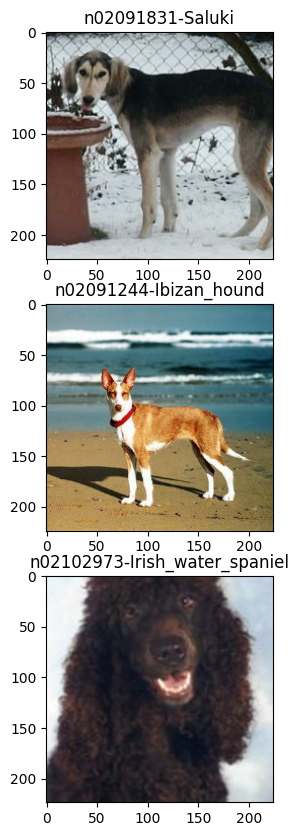

In [9]:
# The different class names
class_names = train_ds.class_names

fig, axes = plt.subplots(3, 1, figsize = (5,10))

for image, label in train_ds.take(1):
    for i in range(3):
        axes[i].imshow(image[i].numpy().astype("uint8"))
        axes[i].set_title(class_names[label[i].numpy().argmax()])


In [16]:
# The breed_list is saved:
with open('breed_list.txt', "w") as f:
    for breed in class_names:
        f.write(f'{breed};')

## 3.1 Data augmentation

Data augmentation is a fast and easy way to add variance to a dataset. This augmentation can take various forms (rotation, flip, distorsion, noise...) and is perfomed in the hope of obtaining a model with a higher level of generalisation. 

The processes of data augmentation descibred in this part have been developped based on the TensorFlow documentation :

https://www.tensorflow.org/tutorials/images/data_augmentation

Data augementation is performed as layers with 4 steps :
- Flip
- Rotation
- Zoom

In [9]:
# Augmentation is performed with keras layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2)
])

Few examples are displayed

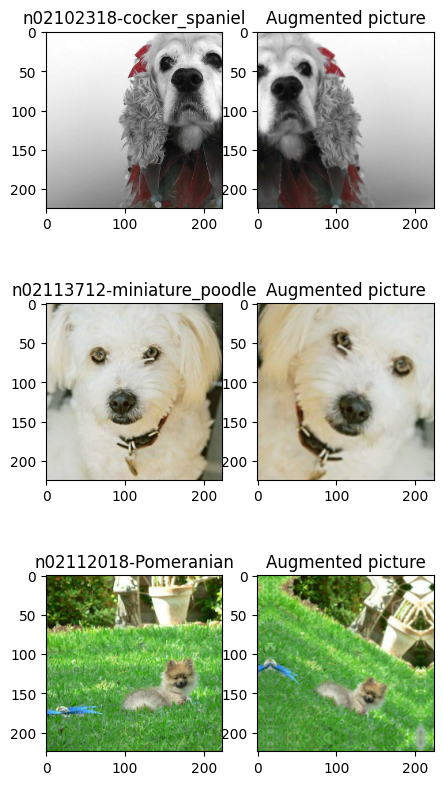

In [17]:
fig, axes = plt.subplots(3, 2, figsize = (5,10))

for image, label in train_ds.take(1):
    for i in range(3):
        axes[i,0].imshow(image[i].numpy().astype("uint8"))
        axes[i,0].set_title(class_names[label[i].numpy().argmax()])
        
        augmented_img = data_augmentation(image[i].numpy().astype("uint8"))
        axes[i,1].imshow(augmented_img)
        axes[i,1].set_title(f'Augmented picture')

The augmentation layers could be applied to the dataset befrohand. However, it can also be incorporated to the model (as input layers) and employed only during model.fit. This way, at each epoch, the train dataset is processed randomly by the augmentation layers.

## 3.2 Images preprocessing

Image preprocessing (as contour detection, equalization ...) can improve model performances by reducing noise in the input data (potentially reducing overfitting). To perform these operations, a tool called "ImageDataGenerator" from "keras.preprocessing" was generally employed. However, the use of this tool according to Keras documentation is deprecated. Instead, the use of skimage as a preprocessing tool for equalization and whitening have been employed.

### 3.2.1 Pixel value centering

A comon preprocessing step in deep learning applied to images is to center the images pixel value (as it is the case is vgg16 as an example). Thus this preprocessing step have been essayed. The mean pixel value have been taken from the training set. The centering of the data have been done as a input layer.

In [10]:
# The mean pixel value for all training images is calculated
pixel_mean_list = []
for image, label in train_ds:
    pixel_mean_list.append(image.numpy().mean())
    
pixel_mean = np.mean(pixel_mean_list)

In [11]:
print('pixel mean value :',pixel_mean)

pixel mean value : 111.592834


In [12]:
# An input layer for centering data is created
center = keras.layers.Lambda(lambda x: x-pixel_mean)

### 3.2.2 ZCA Whitening

The ZCA Whitening procedure was inspired from https://www.kdnuggets.com/2018/10/preprocessing-deep-learning-covariance-matrix-image-whitening.html/3 and keras code : https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/image_data_generator.py

In [21]:
def img_resize(img, size_out):
    img = Image.fromarray(img)
    img = img.resize(size_out)
    return np.array(img)

def whitening_fit(dataset, epsilon = 0.01):
    '''
    Function that allows to fit a whitening filter to the dataset
    The whitening filter can later be used calling whitening()
    '''
    # A sufficient number of sample should be considered
    # However to save processing capacities, only a part of
    # the dataset is used for the fit
    x = np.array([image for image, _ in dataset.take(40).unbatch()])

    # First images are resized (to ease covariance calculations)
    images_res = np.zeros((x.shape[0], 32,32, 3))
    index = 0
    for img in x:
        img = img.astype("uint8")
        images_res[index] = img_resize(img, (32,32))
        index += 1
    
    # Images are scaled and centered
    x_sc = images_res/255.
    x_norm =  x_sc - x_sc.mean(axis = 0)
    
    n = len(x_norm) # number of images
    
    # The images are flattened
    flat_x = np.reshape(x_norm, (n, -1))
    
    # Eigen value decomposition is calculated
    u, s, _ = np.linalg.svd(flat_x.T, full_matrices=False)
    
    whitening_matrix = u.dot(np.diag(1.0/np.sqrt(s + epsilon))).dot(u.T)
        
    
    return whitening_matrix
    
def whitening(whitening_matrix, images):
    '''
    Allow to apply a whitening matrix (pretrained with
    whitening_fit())
    '''
    # First images are resized (to ease covariance calculations)
    images_res = np.zeros((images.shape[0], 32,32, 3))
    index = 0
    
    for img in images:
        img = img.numpy().astype("uint8")
        images_res[index] = img_resize(img, (32,32))
        index += 1
    
    # Images are scaled and centered
    x_sc = images_res/255.
    x_norm =  x_sc - x_sc.mean(axis = 0)
    
    n = len(x_norm) # number of images
    
    # The images are flattened
    flat_x = np.reshape(x_norm, (n, -1))
    
    # whitening matrix is applied to x
    W_white = whitening_matrix.dot(flat_x.T).T
    
    # The image is re set beween 0 and 1
    W_white = (W_white - W_white.min()) / (W_white.max() - W_white.min())
    
    # The image is reshaped to original shape
    W_white = np.reshape(W_white, images_res.shape)
    return W_white

In [22]:
zca_whitening = whitening_fit(train_ds, epsilon = 0.1)

Examples of preprocessed images are displayed

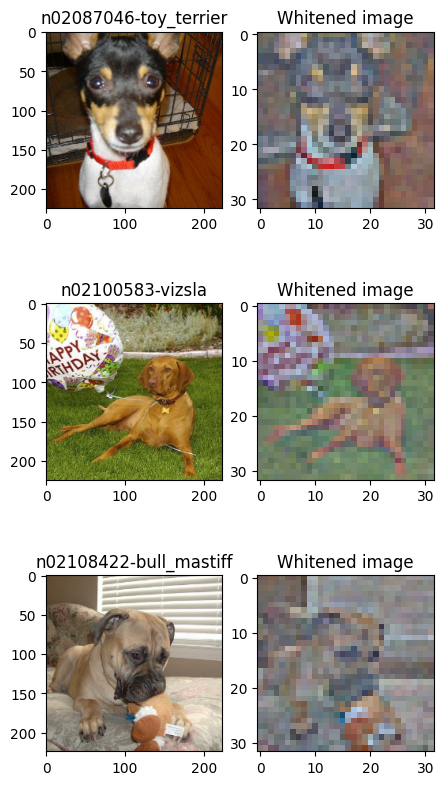

In [23]:
fig, axes = plt.subplots(3, 2, figsize = (5,10))
for image, label in train_ds.take(1):
    for i in range(3):
        img = image[i].numpy().astype("uint8")
        axes[i,0].imshow(img)
        axes[i,0].set_title(class_names[label[i].numpy().argmax()])

        img_w = whitening(zca_whitening, image)[i]
        axes[i,1].imshow(img_w)
        axes[i,1].set_title('Whitened image')
        
plt.show()

### 3.2.3 Equalisation

Image equalization is a method that allows to automatically adjust the contrast of a given picture. Several methods of equalizations exist and thus three are demonstrated here. The equalization is performed thanks to the library Skimage, the image processing library of SciKit-Learn. More info and part of the code can be found at https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py

In [24]:
def img_hist(image, ax):
    """
    For displaying images histograms
    """
    image = img_as_float(image)

    # Display histogram
    ax.hist(image.ravel(), bins=244, histtype='step', color= c_0)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax.set_xlabel('Pixel intensity')
    ax.set_xlim(0, 1)
    ax.set_yticks([])

    # Display cumulative distribution
    ax1 = ax.twinx()
    img_cdf, bins = exposure.cumulative_distribution(image, 244)
    ax1.plot(bins, img_cdf, color = c_1)
    ax1.set_yticks([])

    return ax1

C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


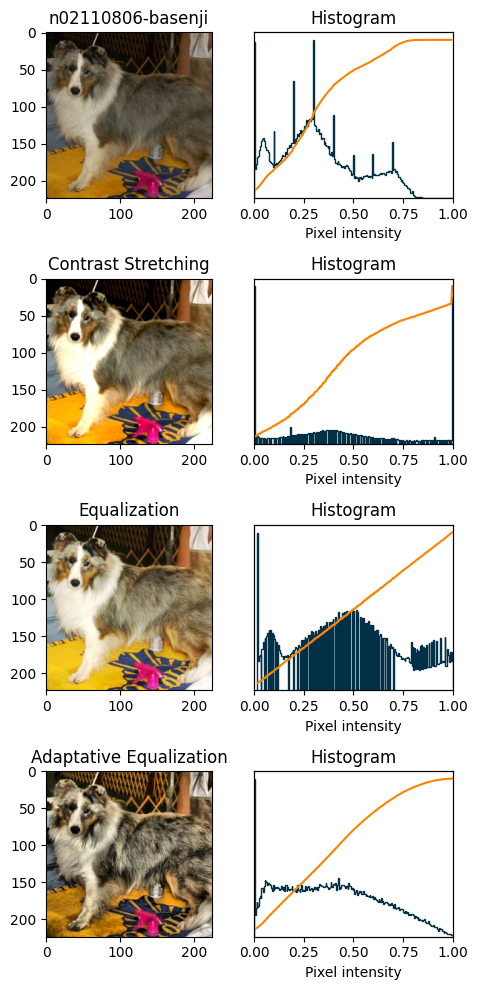

In [25]:
fig, axes = plt.subplots(4, 2, figsize = (5,10))
for image, label in train_ds.take(1):
    
    
    # Unchanged image
    ## Display image
    img = image[0].numpy().astype("uint8")
    axes[0,0].imshow(img)
    axes[0,0].set_title(class_names[label[i].numpy().argmax()])
    
    ## Display histogram
    axes[0,1]= img_hist(img, axes[0,1])
    axes[0,1].set_title('Histogram')
    
    
    # Contrast stretching
    p2, p98 = np.percentile(img, (10, 90))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    ## Display image
    axes[1,0].imshow(img_rescale)
    axes[1,0].set_title('Contrast Stretching')
    
    ## Display histogram
    axes[1,1]= img_hist(img_rescale, axes[1,1])
    axes[1,1].set_title('Histogram')
    
    
    # Equalization
    img_eq = exposure.equalize_hist(img)
    
    ## Display image
    axes[2,0].imshow(img_eq)
    axes[2,0].set_title('Equalization')
    
    ## Display histogram
    axes[2,1]= img_hist(img_eq, axes[2,1])
    axes[2,1].set_title('Histogram')
    
    # Adaptative equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.02)
    
    ## Display image
    axes[3,0].imshow(img_adapteq)
    axes[3,0].set_title('Adaptative Equalization')
    
    ## Display histogram
    axes[3,1]= img_hist(img_adapteq, axes[3,1])
    axes[3,1].set_title('Histogram')
    
    
    
plt.tight_layout()
plt.show()

It is interesting to observe that contrast stretching, equalization and adaptative equalization in this order appears as technic revealing at each step more features.Thus, adaptative equalization seems to be the technic that results in the high feature magnifying.

### 3.2.4 Contour detection

A common image preprocessing tool is contour detection. It allows highlighting object contours in an image. Previously employed for feature detection is image recognition (without deep learning) it can now be used to reduce the noise in the input data and thus improve the neural network generalization.

Several technics of contour detections have been developped. Here as a demonstration, the Prewitt, Sobel and Scharr contour detection technics have been essayed.

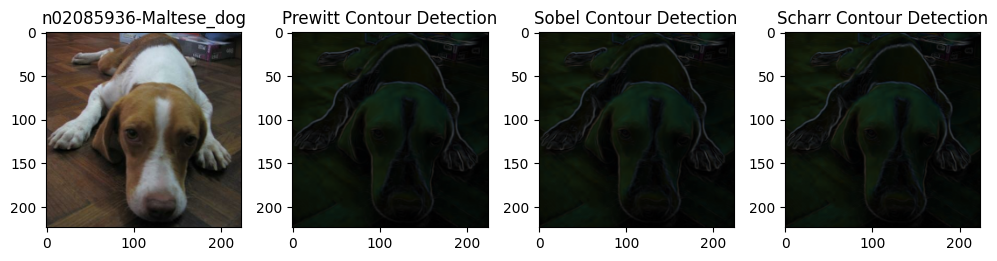

In [26]:
fig, axes = plt.subplots(1, 4, figsize = (10,5))
for image, label in train_ds.take(1):
    
    
    # Unchanged image
    ## Display image
    img = image[0].numpy().astype("uint8")
    axes[0].imshow(img)
    axes[0].set_title(class_names[label[i].numpy().argmax()])
    
    ## Prewitt
    img_pr = filters.prewitt(img)
    axes[1].imshow(img_pr)
    axes[1].set_title('Prewitt Contour Detection')
    
    img_sob = filters.sobel(img)
    axes[2].imshow(img_sob)
    axes[2].set_title('Sobel Contour Detection')
    
    img_sch = filters.scharr(img)
    axes[3].imshow(img_sch)
    axes[3].set_title('Scharr Contour Detection')

plt.tight_layout()
plt.show()

The contour detection algorithms resulted in similar results.

### 3.2.5 The superimposition of features highlighting technics

As a test an image have processed combining multiple technique in order to reduce a maximum of the noise in images and thus ease the learning of the neural network.

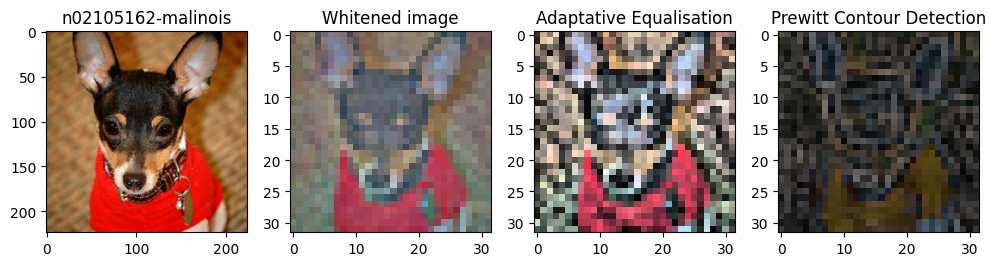

In [27]:
fig, axes = plt.subplots(1, 4, figsize = (10,5))
for image, label in train_ds.take(1):

    # Unchanged image
    img = image[0].numpy().astype("uint8")
    axes[0].imshow(img)
    axes[0].set_title(class_names[label[i].numpy().argmax()])
    
    # Whitening
    img_w = whitening(zca_whitening, image)[0]
    axes[1].imshow(img_w)
    axes[1].set_title('Whitened image')
    
    # Adaptative equalization
    img_adapteq = exposure.equalize_adapthist(img_w, clip_limit=0.02)
    axes[2].imshow(img_adapteq)
    axes[2].set_title('Adaptative Equalisation')
    
    ## Prewitt
    img_pr = filters.prewitt(img_adapteq)
    axes[3].imshow(img_pr)
    axes[3].set_title('Prewitt Contour Detection')


plt.tight_layout()
plt.show()

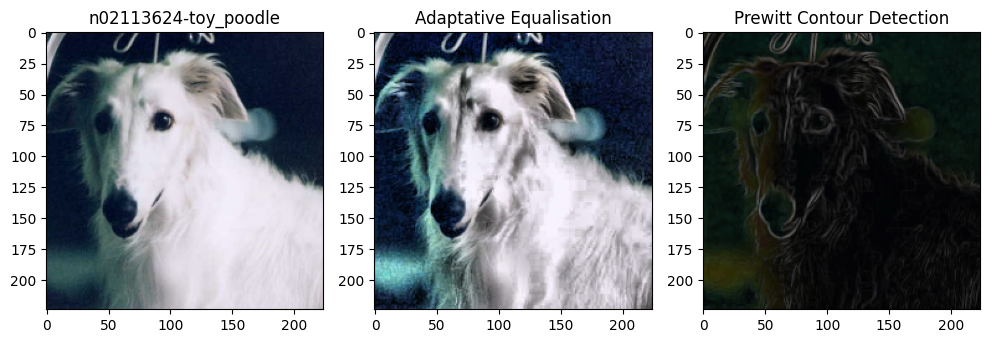

In [28]:
fig, axes = plt.subplots(1, 3, figsize = (10,5))
for image, label in train_ds.take(1):

    # Unchanged image
    img = image[0].numpy().astype("uint8")
    axes[0].imshow(img)
    axes[0].set_title(class_names[label[i].numpy().argmax()])
    
    # Adaptative equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.02)
    axes[1].imshow(img_adapteq)
    axes[1].set_title('Adaptative Equalisation')
    
    ## Prewitt
    img_pr = filters.prewitt(img_adapteq)
    axes[2].imshow(img_pr)
    axes[2].set_title('Prewitt Contour Detection')


plt.tight_layout()
plt.show()

In this context, it appears that adaptative equalization and contour detection allow a better highlight of the image features. Indeed, the whitening technic requires a high reduction of the pictures resolution in order to save computational resources. The other mentioned technique requires way fewer resources for results with high features magnification.

# 4. Trainning a CNN from scratch

## 4.1 From raw data

A first model is built from scratch. The architecture of the model is inspired from VGG-16. However, trainning VGG-16 would result in too long processing time, thus, some convolutional layers have been removed in order to ease the model learning. In the same way, the final dense layers have been lighten in order to same computational resources.

**Model :**

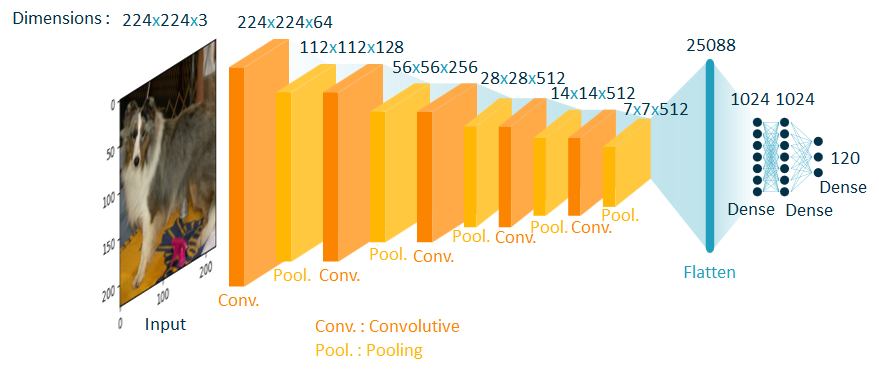

In [35]:
# An empty model is created
model = Sequential()

# Block 1
## Conv1
model.add(Conv2D(64, (3,3),
                   input_shape=(img_height, img_width, 3),
                   padding = 'same',
                   activation = 'relu'))


# Adding pooling layer
model.add(MaxPooling2D(pool_size = (2,2),
                         strides = (2,2)))

# Block 2
## Conv1

## Conv2
model.add(Conv2D(128, (3,3),
                   padding = 'same',
                   activation = 'relu'))

## pooling layer
model.add(MaxPooling2D(pool_size = (2,2),
                         strides = (2,2)))

# Block 3
## Conv1
model.add(Conv2D(256, (3,3),
                   input_shape=(img_height, img_width, 3),
                   padding = 'same',
                   activation = 'relu'))


## pooling layer
model.add(MaxPooling2D(pool_size = (2,2),
                         strides = (2,2)))

# Block 4
## Conv1
model.add(Conv2D(512, (3,3),
                   input_shape=(img_height, img_width, 3),
                   padding = 'same',
                   activation = 'relu'))

## pooling layer
model.add(MaxPooling2D(pool_size = (2,2),
                         strides = (2,2)))

# Block 5
## Conv1
model.add(Conv2D(512, (3,3),
                   input_shape=(img_height, img_width, 3),
                   padding = 'same',
                   activation = 'relu'))


## pooling layer
model.add(MaxPooling2D(pool_size = (2,2),
                         strides = (2,2)))

# Adding fully connected layers
## First flattening to 1D
model.add(Flatten())

## Dense1
model.add(Dense(1024, activation ='relu'))

## Dropout to limit overfitting
# model.add(Dropout(0.2))

## Dense 2
model.add(Dense(1024, activation ='relu'))

## Dense 3 (To output layer)
model.add(Dense(len(class_names), activation ='softmax'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 512)      

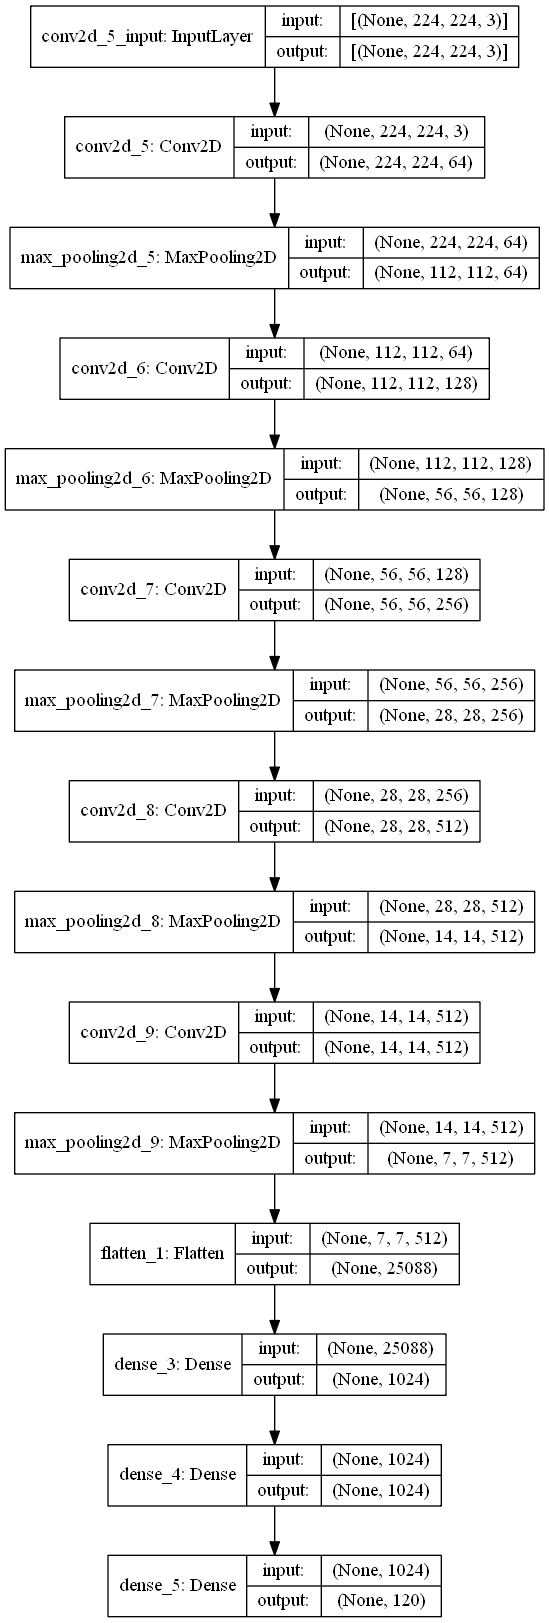

In [37]:
keras.utils.plot_model(model, 'model_1(Raw).png', show_shapes=True)

In [38]:
# Optimize dataset fetching and keep it in cache 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

TensorBoard is used to check and optimise models performances

In [39]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_{int(time.time())}"

tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

In [40]:
# The model is trained 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 1e-6),
              metrics=["categorical_accuracy"])

epochs = 10

history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=epochs,
                    callbacks = [tensorboard])

Epoch 1/10
579/579 [==============================] - 43s 73ms/step - loss: 5.0169 - categorical_accuracy: 0.0185 - val_loss: 4.7047 - val_categorical_accuracy: 0.0258
Epoch 2/10
579/579 [==============================] - 41s 70ms/step - loss: 4.5271 - categorical_accuracy: 0.0438 - val_loss: 4.5407 - val_categorical_accuracy: 0.0369
Epoch 3/10
579/579 [==============================] - 41s 70ms/step - loss: 4.2414 - categorical_accuracy: 0.0772 - val_loss: 4.4163 - val_categorical_accuracy: 0.0564
Epoch 4/10
579/579 [==============================] - 41s 70ms/step - loss: 3.9277 - categorical_accuracy: 0.1273 - val_loss: 4.3851 - val_categorical_accuracy: 0.0622
Epoch 5/10
579/579 [==============================] - 41s 70ms/step - loss: 3.5729 - categorical_accuracy: 0.1919 - val_loss: 4.4225 - val_categorical_accuracy: 0.0690
Epoch 6/10
579/579 [==============================] - 41s 70ms/step - loss: 3.1628 - categorical_accuracy: 0.2709 - val_loss: 4.5327 - val_categorical_accuracy:

The models have been supervised with tensorboard. This way the train and validation loss and accuracy could be observed depending on epochs. The first model evaluated allowed to obtain the following peroformances :

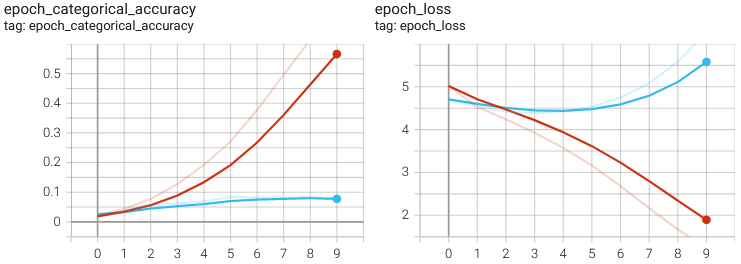
<span style="color:#CC3311;font-weight:bold;">○ Train</span>
<span style="color:#33BBEE;font-weight:bold;" >○ Validation</span>

The high train accuracy for low validation accuracy (as well as the low train loss and high validation loss) indicates clear overfitting. Indeed, the large number of parameters of the model combined with the low number of samples makes it easy for the model to memorize the dataset. A dropout layer is a common method employed to limit overfitting by limiting model memorization.

A similar model including a dropout layer between its dense layers (more prone to memorization) have been assessed with the following performances :

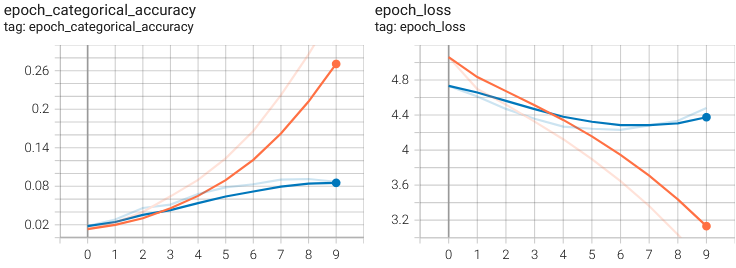
<span style="color:#FF7043;font-weight:bold;">○ Train</span>
<span style="color:#0077BB;font-weight:bold;" >○ Validation</span>

It appears that the dropout layer limited overfitting in the first part of the training. However, after 4 epochs clear overfitting can be observed again.

## 4.2 With data augmentation

In [17]:
# Augmentation is performed with keras layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2)
])

model_2 =  Sequential([
    data_augmentation,
    Conv2D(64, (3,3), # Block 1
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(128, (3,3), # Block 2
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(256, (3,3), # Block 3
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(512, (3,3), # Block 4
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(512, (3,3), # Block 5
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Flatten(), # Flatten
    Dense(1024, activation ='relu'), # Dense 1
    Dense(1024, activation ='relu'), # Dense 2
    Dense(len(class_names), activation ='softmax') # Output
])

model_2.build(input_shape = tuple(train_ds._flat_shapes[0]))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)      

In [43]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_aug_{int(time.time())}"

tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# Data are enhanced


# The model is trained 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 1e-6),
                metrics=["categorical_accuracy"])
model_2.save_weights('model_2')

epochs = 50

history = model_2.fit(train_ds,
                      validation_data = val_ds,
                      epochs=epochs,
                      callbacks = [tensorboard])

Epoch 1/50
579/579 [==============================] - 45s 75ms/step - loss: 4.0662 - categorical_accuracy: 0.0943 - val_loss: 4.1878 - val_categorical_accuracy: 0.0739
Epoch 2/50
579/579 [==============================] - 42s 73ms/step - loss: 3.9897 - categorical_accuracy: 0.1084 - val_loss: 4.1364 - val_categorical_accuracy: 0.0792
Epoch 3/50
579/579 [==============================] - 43s 74ms/step - loss: 3.9081 - categorical_accuracy: 0.1192 - val_loss: 4.1236 - val_categorical_accuracy: 0.0923
Epoch 4/50
579/579 [==============================] - 43s 74ms/step - loss: 3.8340 - categorical_accuracy: 0.1289 - val_loss: 4.1272 - val_categorical_accuracy: 0.0938
Epoch 5/50
579/579 [==============================] - 43s 74ms/step - loss: 3.7573 - categorical_accuracy: 0.1435 - val_loss: 4.1547 - val_categorical_accuracy: 0.0982
Epoch 6/50
579/579 [==============================] - 42s 73ms/step - loss: 3.6904 - categorical_accuracy: 0.1539 - val_loss: 4.1581 - val_categorical_accuracy:

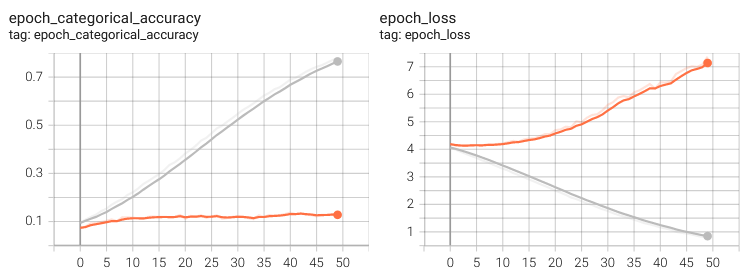
<span style="color:#FF7043;font-weight:bold;">○ Train</span>
<span style="color:#BBBBBB;font-weight:bold;" >○ Validation</span>

## 4.3 From preprocessed data

In the part 3 of this project, several methods of images preprocessing have been assessed. These methods will now be put to use in order to :
- Augment data in the hope of limiting overffiting.
- Extract features to improve the model performances.

First the data are preprocessed by adaptative equalization and Prewitt contour detection (see part 3.2).

Then, an augmentation layer is added to the model in order to generate diversity in the dataset at each epoch.

https://stackoverflow.com/questions/57605021/including-advanced-computation-scikit-like-in-a-keras-custom-layer

In [44]:
# Create a directory to store transformed images
if not os.path.isdir('Images_trans'):
    os.mkdir('Images_trans')

    

    # Loop trought the dataset to convert all images
    for images, labels in train_ds:
        for i in range(images.shape[0]):
            # If the breed directory doesn't exist it is created
            breed_name = class_names[labels[i].numpy().argmax()]
            if not os.path.isdir(f'Images_trans/{breed_name}'):
                os.mkdir(f'Images_trans/{breed_name}')

            # The image is converted 
            img = images[i].numpy().astype("uint8")
            img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.02)
            img_pr = filters.prewitt(img_adapteq)

            # The new image is saved
            pic_name = f"{breed_name} {len(os.listdir(f'Images_trans/{breed_name}'))}"
            name = (f'Images_trans/{breed_name}/{pic_name}.png')
            imsave(name, img_as_ubyte(img_pr))

In [45]:
# A training-validation split of 0.1 is done
train_ds_trans = tf.keras.utils.image_dataset_from_directory(
    'Images_trans',
    labels='inferred',
    label_mode = 'categorical',
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size)

Found 18522 files belonging to 120 classes.
Using 16670 files for training.


In [46]:
val_ds_trans = tf.keras.utils.image_dataset_from_directory(
    'Images_trans',
    labels='inferred',
    label_mode = 'categorical',
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size)

Found 18522 files belonging to 120 classes.
Using 1852 files for validation.


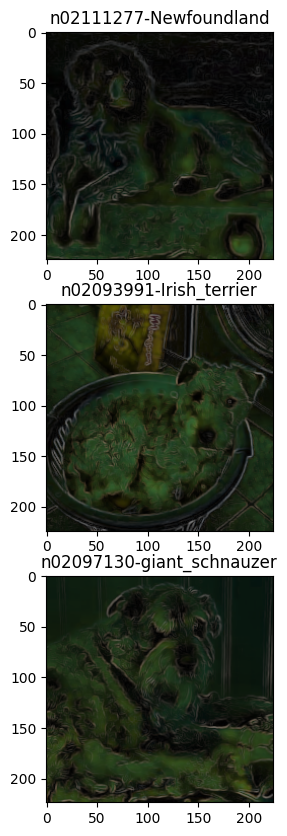

In [47]:
# The different class names
class_names_trans = train_ds_trans.class_names

fig, axes = plt.subplots(3, 1, figsize = (5,10))

for image, label in train_ds_trans.take(1):
    for i in range(3):
        axes[i].imshow(image[i].numpy().astype("uint8"))
        axes[i].set_title(class_names_trans[label[i].numpy().argmax()])

The data augmentation layer is initialised and added to the achitecture of the model 2 as a first layer. The model is then built to indicate the input shape.

It has also been observed that a larger number of epochs was necessary in order to conclude on the results

In [48]:
# Augmentation is performed with keras layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2)
])

In [49]:
model_2 =  Sequential([
    data_augmentation,
    center,
    Conv2D(64, (3,3), # Block 1
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(128, (3,3), # Block 2
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(256, (3,3), # Block 3
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(512, (3,3), # Block 4
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Conv2D(512, (3,3), # Block 5
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),
                 strides = (2,2)),
    Flatten(), # Flatten
    Dense(1024, activation ='relu'), # Dense 1
    Dense(1024, activation ='relu'), # Dense 2
    Dense(len(class_names_trans), activation ='softmax') # Output
])

In [50]:
model_2.build(input_shape = tuple(train_ds_trans._flat_shapes[0]))
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [51]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_prep_cent_{int(time.time())}"

tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# Data are enhanced


# The model is trained 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 1e-6),
                metrics=["categorical_accuracy"])
model_2.save_weights('model_2')

epochs = 30

history = model_2.fit(train_ds,
                      validation_data = val_ds,
                      epochs=epochs,
                      callbacks = [tensorboard])

Epoch 1/30
579/579 [==============================] - 49s 80ms/step - loss: 4.8621 - categorical_accuracy: 0.0187 - val_loss: 4.6439 - val_categorical_accuracy: 0.0350
Epoch 2/30
579/579 [==============================] - 45s 76ms/step - loss: 4.5325 - categorical_accuracy: 0.0374 - val_loss: 4.4607 - val_categorical_accuracy: 0.0432
Epoch 3/30
579/579 [==============================] - 45s 76ms/step - loss: 4.3798 - categorical_accuracy: 0.0515 - val_loss: 4.3520 - val_categorical_accuracy: 0.0588
Epoch 4/30
579/579 [==============================] - 46s 77ms/step - loss: 4.2730 - categorical_accuracy: 0.0637 - val_loss: 4.2768 - val_categorical_accuracy: 0.0675
Epoch 5/30
579/579 [==============================] - 45s 76ms/step - loss: 4.1807 - categorical_accuracy: 0.0755 - val_loss: 4.2308 - val_categorical_accuracy: 0.0709
Epoch 6/30
579/579 [==============================] - 45s 76ms/step - loss: 4.0964 - categorical_accuracy: 0.0876 - val_loss: 4.1975 - val_categorical_accuracy:

First the model has been trained on 10 epochs. As the results were non-conclusive, the model was trained again on 20 more epochs. The following results were obtained :

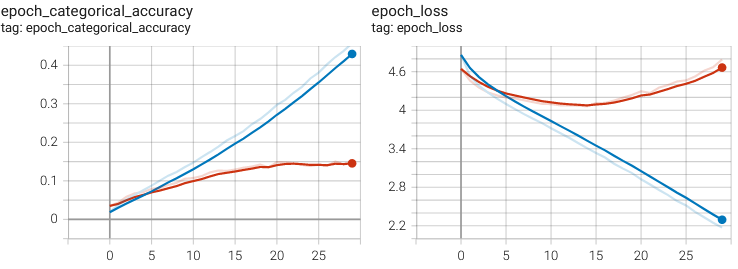
<span style="color:#CC3311;font-weight:bold;">○ Train</span>
<span style="color:#0077BB;font-weight:bold;" >○ Validation</span>


Again, the difference between the train and validation accuracy and loss suggest an overfitting of the model. Even though the data are augmented before getting fed to the model (with random rotation, zoom...) the model achieves to memorize the training data. This is explained by the low number of samples compared to the large number of targets (i.e., breeds). Trying to predict a lower number of breeds could allow higher performances and reduce overfitting.

The model has again been initialized and essayed this time for the prediction of only 5 breeds. The same methodology has then been applied with only two breeds. This way it is possible to discuss the influence of the number of targets on the model performances.

## 4.4 With a reduced number of targets

In order to gain a higher control on the number of breeds imported in the dataset, a custom import method have been developped allowing to chose the breeds to import.

The function was inspired of <a href=https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control> TensorFlow documentation </a>

In [52]:
# Functions are created to extract labels
# and import images in the right format
def get_label(file_path):
    '''
    Get labels and convert them to onehot encoding
    '''
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the breed name
    # The label is onehot encoded through boolean indexing
    one_hot = parts[-2] == breed_names
    # Integer encode the label
    return tf.cast(one_hot, tf.int32)

def decode_img(img):
    '''
    Import images in the right format and size
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    '''
    Return the (img, label) pair from file path
    '''
    # Get the label
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert image to uit8 tensor
    img = decode_img(img)
    return img, label

def configure_for_performance(ds):
    '''
    Improve dataset performance through shuffuling, batching
    and prefetching
    '''
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [53]:
def import_cutom_breed(breed_names):
    # Find all the files paths
    file_list = []
    for breed in breed_names:
        file_list.extend(glob.glob(f'Images\\{breed}/*', recursive=False))

    # Create a dataset from the path names
    list_ds = tf.data.Dataset.from_tensor_slices(file_list)

    # The dataset is split between a train and validation set
    val_size = int(len(file_list) * 0.3)
    train_ds_cust = list_ds.skip(val_size)
    val_ds_cust = list_ds.take(val_size)

    print(f'train set created with {tf.data.experimental.cardinality(train_ds_cust).numpy()} elements')
    print(f'val set created with {tf.data.experimental.cardinality(val_ds_cust).numpy()} elements')
    
    # The (img, label) pair is formed from .map function
    ## Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds_cust = train_ds_cust.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds_cust = val_ds_cust.map(process_path, num_parallel_calls=AUTOTUNE)

    # Now that the dataset have been created, it can be optimized for performances. 
    # The dataset is shuffled, batched and batches are prefetched to accelerate processing.
    train_ds_cust = configure_for_performance(train_ds_cust)
    val_ds_cust = configure_for_performance(val_ds_cust)
    
    return train_ds_cust, val_ds_cust

### 4.4.1 Predicting 5 breeds

In this part, 5 breed have been picked for training and evaluation the model. This time a model inspired of the structure of the algorithm "AlexNet" have been built. This algorithm have been described as highly performant for image classification form the ImageNet dataset <a href=https://en.wikipedia.org/wiki/AlexNet> Source </a>. In order to hinder overfitting, data have been augmented with a data augmentation layer. Moreover, layers of dropout as well as batch normalization have been inserted in the model.

In [54]:
breed_names = np.random.choice(breed_list, 5, replace = False)
breed_names = ['n02086646-Blenheim_spaniel', 'n02087046-toy_terrier', 'n02090379-redbone',
       'n02094433-Yorkshire_terrier', 'n02116738-African_hunting_dog']

train_ds_cust, val_ds_cust = import_cutom_breed(breed_names)

train set created with 589 elements
val set created with 252 elements


In [55]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.4),
    RandomZoom(0.4),
])

model_3 =  Sequential([
    data_augmentation,
    center,
    
    Conv2D(96, (11,11), # Block 1
           input_shape=(img_height, img_width, 3),
           padding = 'valid',
           strides = (4,4)),
    Activation('relu'),
    MaxPooling2D((2,2),
                 strides = (2,2),
                 padding = 'valid'),
    
    Conv2D(256, (11,11), # Block 1
           padding = 'valid',
           strides = (1,1)),
    Activation('relu'),
    MaxPooling2D((2,2),
                 strides = (2,2),
                 padding = 'valid'),

    Conv2D(384, (3,3), # Block 1
           padding = 'valid',
           strides = (1,1)),
    Activation('relu'),

    Conv2D(384, (3,3), # Block 1
           padding = 'valid',
           strides = (1,1)),
    Activation('relu'),
    
    Conv2D(256, (3,3), # Block 1
           padding = 'valid',
           strides = (1,1)),
    Activation('relu'),
    
    Flatten(), # Flatten
    Dense(4096, input_shape=(img_height*img_width*3,)), # Dense 2
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(4096), # Dense 2
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    
    Dense(1000), # Dense 2
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    
    Dense(len(breed_names)), # Output
    Activation('softmax')
])

model_3.build(input_shape = tuple(train_ds_cust._flat_shapes[0]))
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)      

In [58]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_cust_5_{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# The model is trained 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adadelta(learning_rate = 1e-4),
                metrics=["categorical_accuracy"])

epochs = 40

history = model_3.fit(train_ds_cust,
                      validation_data = val_ds_cust,
                      epochs=epochs,
                      callbacks = [tensorboard])

Epoch 1/40
19/19 [==============================] - 4s 117ms/step - loss: 2.0961 - categorical_accuracy: 0.1935 - val_loss: 1.5151 - val_categorical_accuracy: 0.3214
Epoch 2/40
19/19 [==============================] - 1s 29ms/step - loss: 2.1066 - categorical_accuracy: 0.2020 - val_loss: 1.5162 - val_categorical_accuracy: 0.3333
Epoch 3/40
19/19 [==============================] - 1s 29ms/step - loss: 2.0642 - categorical_accuracy: 0.2105 - val_loss: 1.5166 - val_categorical_accuracy: 0.3333
Epoch 4/40
19/19 [==============================] - 1s 28ms/step - loss: 2.0641 - categorical_accuracy: 0.2122 - val_loss: 1.5162 - val_categorical_accuracy: 0.3373
Epoch 5/40
19/19 [==============================] - 1s 29ms/step - loss: 2.0570 - categorical_accuracy: 0.2309 - val_loss: 1.5207 - val_categorical_accuracy: 0.3214
Epoch 6/40
19/19 [==============================] - 1s 29ms/step - loss: 2.1046 - categorical_accuracy: 0.2122 - val_loss: 1.5232 - val_categorical_accuracy: 0.3095
Epoch 7/4

The following results were obtained :

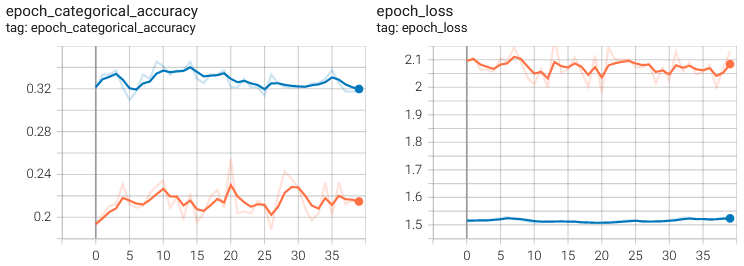
<span style="color:#FF7043;font-weight:bold;">○ Train</span>
<span style="color:#0077BB;font-weight:bold;" >○ Validation</span>

After optimization of the model, the best performances were obtained with an accuracy between 0.22 (train) and 0.33 (validation). It is interesting to note that validation get a higher accuracy when compared to train. This could be explained by the low number of samples, increasing the chance of inhomogeneous sampling between the train and validation set.

### 4.4.2 Predicting 2 breeds

Finaly, a simplified model is optimized for binary classification. The model is trained on only two breeds.

In [78]:
breed_names = np.random.choice(breed_list, 2, replace = False)

train_ds_cust, val_ds_cust = import_cutom_breed(breed_names)

train set created with 228 elements
val set created with 97 elements


In [79]:
breed_names

array(['n02088238-basset', 'n02102973-Irish_water_spaniel'], dtype='<U40')

In [80]:
model_3 =  Sequential([
    data_augmentation,
    Conv2D(64, (3,3), # Block 1
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (5,5),
                 strides = (2,2)),
    Conv2D(64, (3,3), # Block 2
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (5,5),
                 strides = (2,2)),
    Conv2D(64, (3,3), # Block 3
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (5,5),
                 strides = (2,2)),
    Conv2D(64, (3,3), # Block 3
           input_shape=(img_height, img_width, 3),
           padding = 'same',
           activation = 'relu'),
    MaxPooling2D(pool_size = (5,5),
                 strides = (2,2)),
    Flatten(), # Flatten
    Dense(len(breed_names), activation ='softmax') # Output
])

model_3.build(input_shape = tuple(train_ds_cust._flat_shapes[0]))
model_3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 110, 110, 64)      36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 25, 25, 64)      

In [81]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_cust_2_{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# The model is trained 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

epochs = 40

history = model_3.fit(train_ds_cust,
                      validation_data = val_ds_cust,
                      epochs=epochs,
                      callbacks = [tensorboard])

Epoch 1/40
8/8 [==============================] - 3s 219ms/step - loss: 25.3263 - accuracy: 0.5614 - val_loss: 31.6706 - val_accuracy: 0.0000e+00
Epoch 2/40
8/8 [==============================] - 0s 50ms/step - loss: 3.2911 - accuracy: 0.5482 - val_loss: 1.3232 - val_accuracy: 0.3196
Epoch 3/40
8/8 [==============================] - 0s 50ms/step - loss: 0.6791 - accuracy: 0.6667 - val_loss: 1.2804 - val_accuracy: 0.2887
Epoch 4/40
8/8 [==============================] - 0s 48ms/step - loss: 0.5883 - accuracy: 0.6535 - val_loss: 0.3348 - val_accuracy: 0.9175
Epoch 5/40
8/8 [==============================] - 0s 48ms/step - loss: 0.5913 - accuracy: 0.6623 - val_loss: 0.7195 - val_accuracy: 0.5464
Epoch 6/40
8/8 [==============================] - 0s 50ms/step - loss: 0.6254 - accuracy: 0.6711 - val_loss: 1.3093 - val_accuracy: 0.2165
Epoch 7/40
8/8 [==============================] - 0s 49ms/step - loss: 0.5789 - accuracy: 0.7061 - val_loss: 0.6811 - val_accuracy: 0.5876
Epoch 8/40
8/8 [====

The following results are obtained :

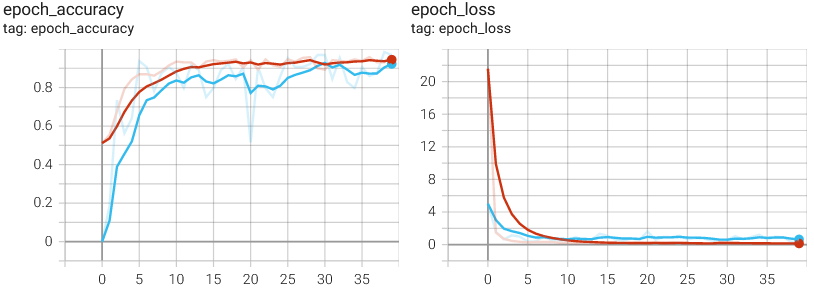
<span style="color:#CC3311;font-weight:bold;">○ Train</span>
<span style="color:#33BBEE;font-weight:bold;" >○ Validation</span>

This time, impressive results were obtained showing that binary classification suits better the model and is matching the data quantity provided.

# 5. Transfer learning

A common solution when only a limited amount of data is available is to use a model that has already been trained on similar data. This way, data are preprocessed by the already trained model for relevant features extraction. Then, dense decision layers need to be trained in order to perform the classification task. Another strategy (but more costly in processing time) is to train the dense layers as well as the first convolutional layers of the pretrained model. This strategy allows fine-tuning the model to the data studied. Finally, a model can be imported and fully trained on the data in order to have a fully data-tuned model. As a low amount of data and computational resources are available in this project, the first two strategies have been assessed.

## 5.1 Transfer learning for feature extraction

The Strategy of transfer learning have been assessed with three popular models : VGG16, ResNet and Xception (<a href=https://keras.io/api/applications/>see</a>). The process for importing a model and using it in a strategy of transfer learning is described in keras documentation (<a href= https://keras.io/guides/transfer_learning/>source</a>)

### 5.1.1 VGG16

The model is loaded.

In [13]:
# The model is downloaded
vgg16 = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_tensor=None,
                                    input_shape=(224, 224, 3),
                                    pooling=None,
                                    classes=len(class_names),
                                    classifier_activation="softmax")


In [23]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

A layer for converting images in a format compatible with the VGG16 model is build (thanks to the layers.Lambda). Then, dense layers are added to the model as output layers for making the prediction. A dropout layer have been added after the vgg16 convolution layers for reducing overfitting.

In [14]:
input_vgg16 = keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x))

In [25]:
vgg16_fe = Sequential([
    data_augmentation,
    input_vgg16,
    vgg16,
    Dropout(0.2),
    Flatten(), # Flatten
    Dense(1024, activation ='relu'), # Dense 1
    Dense(1024, activation ='relu'), # Dense 2
    Dense(len(class_names), activation ='softmax') # Output
])
vgg16_fe.layers[2].trainable = False
vgg16_fe.build(input_shape = tuple(train_ds._flat_shapes[0]))
vgg16_fe.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

In [26]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_tl_fe{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# The model is trained 
vgg16_fe.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["categorical_accuracy"])

epochs = 10

history = vgg16_fe.fit(train_ds,
                      validation_data = val_ds,
                      epochs=epochs,
                      callbacks = [tensorboard])

Epoch 1/10
579/579 [==============================] - 53s 89ms/step - loss: 5.9012 - categorical_accuracy: 0.1014 - val_loss: 3.9791 - val_categorical_accuracy: 0.1467
Epoch 2/10
579/579 [==============================] - 51s 87ms/step - loss: 3.4462 - categorical_accuracy: 0.2076 - val_loss: 3.0413 - val_categorical_accuracy: 0.2945
Epoch 3/10
579/579 [==============================] - 50s 86ms/step - loss: 2.3442 - categorical_accuracy: 0.3702 - val_loss: 2.1685 - val_categorical_accuracy: 0.4466
Epoch 4/10
579/579 [==============================] - 50s 87ms/step - loss: 1.8954 - categorical_accuracy: 0.4632 - val_loss: 2.0705 - val_categorical_accuracy: 0.4879
Epoch 5/10
579/579 [==============================] - 51s 87ms/step - loss: 1.6749 - categorical_accuracy: 0.5158 - val_loss: 1.8521 - val_categorical_accuracy: 0.5340
Epoch 6/10
579/579 [==============================] - 51s 87ms/step - loss: 1.5698 - categorical_accuracy: 0.5443 - val_loss: 1.9356 - val_categorical_accuracy:

Good performances with an accuracy between 0.53 (validation) and 0.52 (train) have been obtained.

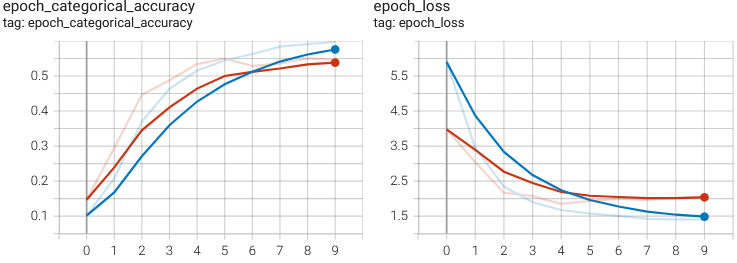
<span style="color:#CC3311;font-weight:bold;">○ Train</span>
<span style="color:#0077BB;font-weight:bold;" >○ Validation</span>

### 5.1.2 ResNet50V2

The model is imported.

In [27]:
resnet = tf.keras.applications.ResNet50V2(include_top=False,
                                          weights="imagenet",
                                          input_tensor=None,
                                          input_shape=(224, 224, 3),
                                          pooling='avg',
                                          classes=len(class_names),
                                          classifier_activation="softmax")

resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

A layer for converting images in a format compatible with the model is build (thanks to the layers.Lambda). Then, dense layers are added to the model as output layers for making the prediction.

In [28]:
input_resnet = keras.layers.Lambda(lambda x: tf.keras.applications.resnet.preprocess_input(x))

In [29]:
resnet_fe = Sequential([
    data_augmentation,
    input_resnet,
    resnet,
    Flatten(), # Flatten
    Dense(512, activation ='relu'), # Dense 1
    Dense(len(class_names), activation ='softmax') # Output
])
resnet_fe.layers[2].trainable = False
resnet_fe.build(input_shape = tuple(train_ds._flat_shapes[0]))
resnet_fe.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_13 (Dense)             (None, 120)               61560     
Total params: 24,675,448
Trainable params: 1,110,648
Non-trainable params: 23,564,800
__________________________________

In [30]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_tl_resnet_fe{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# The model is trained 
resnet_fe.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["categorical_accuracy"])

epochs = 10

history = resnet_fe.fit(train_ds,
                        validation_data = val_ds,
                        epochs=epochs,
                        callbacks = [tensorboard])

C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
579/579 [==============================] - 49s 78ms/step - loss: 70.0675 - categorical_accuracy: 0.0103 - val_loss: 43.4955 - val_categorical_accuracy: 0.0180
Epoch 2/10
579/579 [==============================] - 40s 70ms/step - loss: 37.5034 - categorical_accuracy: 0.0126 - val_loss: 33.2505 - val_categorical_accuracy: 0.0170
Epoch 3/10
579/579 [==============================] - 39s 67ms/step - loss: 29.3806 - categorical_accuracy: 0.0138 - val_loss: 26.6518 - val_categorical_accuracy: 0.0170
Epoch 4/10
579/579 [==============================] - 39s 67ms/step - loss: 24.3267 - categorical_accuracy: 0.0159 - val_loss: 22.6976 - val_categorical_accuracy: 0.0155
Epoch 5/10
579/579 [==============================] - 39s 67ms/step - loss: 13.5294 - categorical_accuracy: 0.0117 - val_loss: 4.9493 - val_categorical_accuracy: 0.0078
Epoch 6/10
579/579 [==============================] - 39s 67ms/step - loss: 4.8116 - categorical_accuracy: 0.0103 - val_loss: 4.8746 - val_categorical_

Even after optimization of the output layer, poor classification performances were obtained, inducating that the model is probably highly data-specific and that the second stratagy (with a re-training of the first layers of the model) could suit better the use of ResNet50 for dog breed classification.

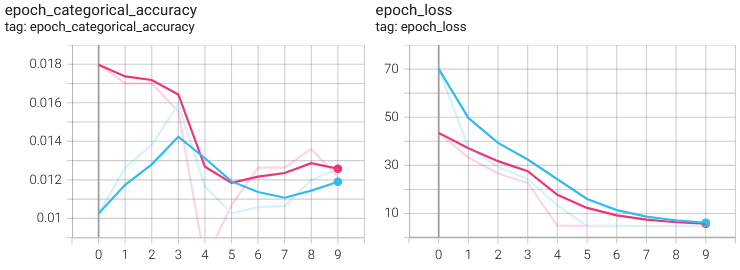

### 5.1.3 Xception

The model is loaded

In [31]:
xception = tf.keras.applications.Xception(include_top=False,
                                          weights="imagenet",
                                          input_tensor=None,
                                          input_shape=(224, 224, 3),
                                          pooling=None,
                                          classes=len(class_names),
                                          classifier_activation="softmax")

xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

A layer for converting images in a format compatible with the model is build (thanks to the layers.Lambda). Then, dense layers are added to the model as output layers for making the prediction.

In [32]:
input_xception = keras.layers.Lambda(lambda x: tf.keras.applications.xception.preprocess_input(x))

In [33]:
xception_fe = Sequential([
    data_augmentation,
    input_xception,
    xception,
    Flatten(), # Flatten
    Dense(1024, activation ='relu'), # Dense 1
    BatchNormalization(),
    Dense(len(class_names), activation ='softmax') # Output
])
xception_fe.layers[2].trainable = False
xception_fe.build(input_shape = tuple(train_ds._flat_shapes[0]))
xception_fe.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_15 (Dense)             (None, 120)              

In [34]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_tl_xception_fe{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

# Save Checkpoint
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="xception_best.tf",
                                                     save_best_only=True,
                                                     save_weights_only=False,
                                                     monitor="val_loss",
                                                     verbose=1)
# The model is trained 
xception_fe.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=["categorical_accuracy"])

epochs = 10

history = xception_fe.fit(train_ds,
                          validation_data = val_ds,
                          epochs=epochs,
                          callbacks = [tensorboard, save_checkpoint])
xception_fe.save('xception_trained')

Epoch 1/10
579/579 [==============================] - 105s 172ms/step - loss: 1.1803 - categorical_accuracy: 0.6957 - val_loss: 0.9233 - val_categorical_accuracy: 0.7687

Epoch 00001: val_loss improved from inf to 0.92326, saving model to xception_best.tf
INFO:tensorflow:Assets written to: xception_best.tf\assets


C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
579/579 [==============================] - 92s 159ms/step - loss: 0.8001 - categorical_accuracy: 0.7705 - val_loss: 0.7685 - val_categorical_accuracy: 0.7881

Epoch 00002: val_loss improved from 0.92326 to 0.76854, saving model to xception_best.tf
INFO:tensorflow:Assets written to: xception_best.tf\assets


C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/10
579/579 [==============================] - 92s 158ms/step - loss: 0.6923 - categorical_accuracy: 0.7924 - val_loss: 0.7461 - val_categorical_accuracy: 0.8027

Epoch 00003: val_loss improved from 0.76854 to 0.74612, saving model to xception_best.tf
INFO:tensorflow:Assets written to: xception_best.tf\assets


C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/10
579/579 [==============================] - 93s 160ms/step - loss: 0.6315 - categorical_accuracy: 0.8091 - val_loss: 0.7555 - val_categorical_accuracy: 0.8056

Epoch 00004: val_loss did not improve from 0.74612
Epoch 5/10
579/579 [==============================] - 91s 157ms/step - loss: 0.5919 - categorical_accuracy: 0.8168 - val_loss: 0.7751 - val_categorical_accuracy: 0.7901

Epoch 00005: val_loss did not improve from 0.74612
Epoch 6/10
579/579 [==============================] - 88s 152ms/step - loss: 0.5540 - categorical_accuracy: 0.8282 - val_loss: 0.7777 - val_categorical_accuracy: 0.7945

Epoch 00006: val_loss did not improve from 0.74612
Epoch 7/10
579/579 [==============================] - 93s 160ms/step - loss: 0.5167 - categorical_accuracy: 0.8382 - val_loss: 0.7459 - val_categorical_accuracy: 0.8017

Epoch 00007: val_loss improved from 0.74612 to 0.74591, saving model to xception_best.tf
INFO:tensorflow:Assets written to: xception_best.tf\assets


C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/10
579/579 [==============================] - 92s 159ms/step - loss: 0.4837 - categorical_accuracy: 0.8456 - val_loss: 0.7621 - val_categorical_accuracy: 0.8081

Epoch 00008: val_loss did not improve from 0.74591
Epoch 9/10
579/579 [==============================] - 92s 158ms/step - loss: 0.4684 - categorical_accuracy: 0.8516 - val_loss: 0.7680 - val_categorical_accuracy: 0.8032

Epoch 00009: val_loss did not improve from 0.74591
Epoch 10/10
579/579 [==============================] - 92s 158ms/step - loss: 0.4342 - categorical_accuracy: 0.8593 - val_loss: 0.7917 - val_categorical_accuracy: 0.7998

Epoch 00010: val_loss did not improve from 0.74591
INFO:tensorflow:Assets written to: xception_trained\assets


C:\Users\alfre\anaconda3\envs\Project_6_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


The following performances were obtained :

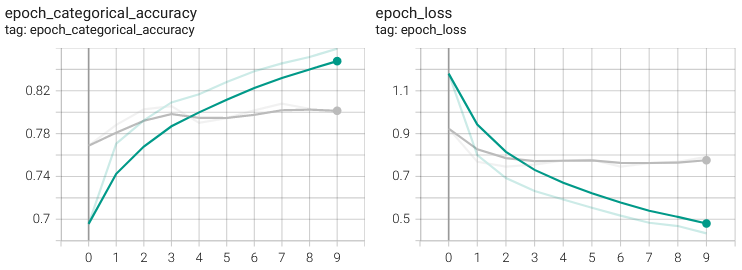
<span style="color:#009887;font-weight:bold;">○ Train</span>
<span style="color:#BBBBBB;font-weight:bold;" >○ Validation</span>

The performances are the best obtained so far. Thanks to the checkpoint callbacks, the model at the epoch 3 (loss: 0.5167 - categorical_accuracy: 0.8382 - val_loss: 0.7459 - val_categorical_accuracy: 0.8017) have been saved, as it corresponds to the epoch with the lower measured validation loss. For a larger number of epochs the model tends to lightly overfit.

## 5.2 Transfer learning with fine-tuning

As described earlier, a strategy of transfer learning with a fine-tuning of the first layers of the model is assessed. The model ResNet50V2 has been assessed as it showed poor performances on our dataset. In comparison, the model VGG16 (as it is the simpler in the selection) have also been tested through this strategy.

### 5.2.1 ResNet50

In [82]:
for layer in resnet.layers:
    layer.trainable = False

for layer in resnet.layers[:17]:
    layer.trainable = True

resnet_ft = Sequential([
    data_augmentation,
    input_resnet,
    resnet,
    Dense(1024, activation ='relu'), # Dense 1
    Dense(1024, activation ='relu'), # Dense 2
    Dense(len(class_names), activation ='softmax') # Output
])
resnet_ft.build(input_shape = tuple(train_ds._flat_shapes[0]))
resnet_ft.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 120)               123000    
Total params: 26,835,576
Trainable params: 3,354,872
Non-trainable params: 23,480,704
__________________________________

In [28]:
# Data are collected in TensorBoard
model_name = f"Breed_sorting_tl_resnet_ft{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')


# The model is trained 
resnet_ft.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

epochs = 10

history = resnet_ft.fit(train_ds,
                        validation_data = val_ds,
                        epochs=epochs,
                        callbacks = [tensorboard])

Epoch 1/10
579/579 [==============================] - 108s 167ms/step - loss: 2.7007 - accuracy: 0.3445 - val_loss: 1.4178 - val_accuracy: 0.5972
Epoch 2/10
579/579 [==============================] - 91s 151ms/step - loss: 1.2927 - accuracy: 0.6227 - val_loss: 1.2615 - val_accuracy: 0.6370
Epoch 3/10
579/579 [==============================] - 91s 151ms/step - loss: 1.1197 - accuracy: 0.6724 - val_loss: 1.1228 - val_accuracy: 0.6812
Epoch 4/10
579/579 [==============================] - 91s 151ms/step - loss: 1.0412 - accuracy: 0.6905 - val_loss: 1.2399 - val_accuracy: 0.6569
Epoch 5/10
579/579 [==============================] - 89s 149ms/step - loss: 0.9657 - accuracy: 0.7115 - val_loss: 1.1238 - val_accuracy: 0.6880
Epoch 6/10
579/579 [==============================] - 89s 149ms/step - loss: 0.9027 - accuracy: 0.7273 - val_loss: 1.2584 - val_accuracy: 0.6638
Epoch 7/10
579/579 [==============================] - 90s 150ms/step - loss: 0.8698 - accuracy: 0.7367 - val_loss: 1.1232 - val_a

The following performances were obtained (here compared with the model without fine-tuning):

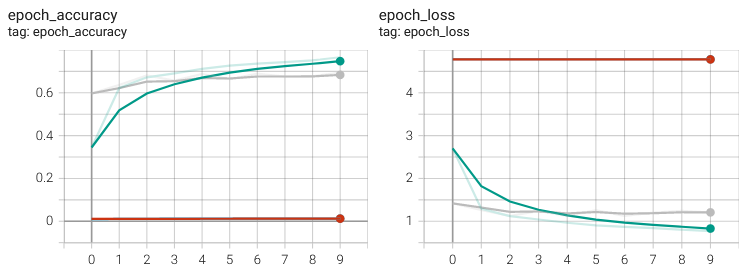

<span style="color:#009988;font-weight:bold;">○ Train</span>

<span style="color:#BBBBBB;font-weight:bold;" >○ Validation</span>

<span style="color:#CD2F0C;font-weight:bold;">○ Train and validation without fine-tuning</span>


This time, thanks to the fine-tuning of the model first layers, higher performances were obtained with validation losses and accuracy value equivalent to the Xception model. Only traces of overfitting can be observed at the end of the model training.

### 5.2.2 VGG16

As a comparison the model VGG16 have been tested with fine-tuning.

In [15]:
for layer in vgg16.layers:
    layer.trainable = False
    
for layer in vgg16.layers[:7]:
    layer.trainable = True

vgg16_ft = Sequential([
    data_augmentation,
    input_vgg16,
    vgg16,
    Flatten(), # Flatten
    Dense(1024, activation ='relu'), # Dense 1
    Dense(1024, activation ='relu'), # Dense 2
    Dense(len(class_names), activation ='softmax') # Output
])

vgg16_ft.build(input_shape = tuple(train_ds._flat_shapes[0]))
vgg16_ft.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 120)              

In [16]:
# The model is trained 
vgg16_ft.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["categorical_accuracy"])

# Data are collected in TensorBoard
model_name = f"Breed_sorting_tl_vgg16_ft{int(time.time())}"
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

epochs = 10

history = vgg16_ft.fit(train_ds,
                      validation_data = val_ds,
                      epochs=epochs,
                      callbacks = [tensorboard])

Epoch 1/10
579/579 [==============================] - 216s 339ms/step - loss: 4.8665 - categorical_accuracy: 0.0124 - val_loss: 4.7627 - val_categorical_accuracy: 0.0155
Epoch 2/10
579/579 [==============================] - 185s 318ms/step - loss: 4.6506 - categorical_accuracy: 0.0169 - val_loss: 4.5956 - val_categorical_accuracy: 0.0204
Epoch 3/10
579/579 [==============================] - 192s 331ms/step - loss: 4.5740 - categorical_accuracy: 0.0207 - val_loss: 4.5402 - val_categorical_accuracy: 0.0185
Epoch 4/10
579/579 [==============================] - 191s 330ms/step - loss: 4.5107 - categorical_accuracy: 0.0275 - val_loss: 4.4137 - val_categorical_accuracy: 0.0350
Epoch 5/10
579/579 [==============================] - 192s 331ms/step - loss: 4.4034 - categorical_accuracy: 0.0341 - val_loss: 4.3652 - val_categorical_accuracy: 0.0364
Epoch 6/10
579/579 [==============================] - 192s 331ms/step - loss: 4.3119 - categorical_accuracy: 0.0415 - val_loss: 4.3606 - val_categoric

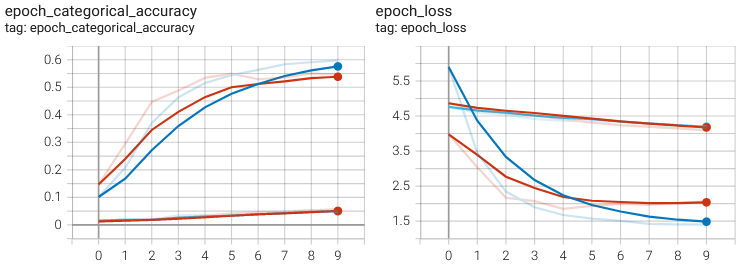<span style="color:#CC3311;font-weight:bold;">○ Train</span>
<span style="color:#0077BB;font-weight:bold;" >○ Validation</span>

Finetuning of the model VGG16 did not improve the model performances as the model seems to not be aible to learn at all in this configuration.

# 6. Final model assessment

The model with the higher performances was the model Xception after 3 epochs. This model is loaded and its performances are studied in detail.

In [17]:
# The model is loaded
final_model = tf.keras.models.load_model('xception_best.tf')

In [98]:
# Prediction are done on the validation dataset
# prediction = final_model.predict(val_ds)
y_true = []
y_pred = []

for batch_img, batch_label in val_ds:
    # Add y_true
    y_true.extend(batch_label.numpy())
    
    # predict y_pred
    prediction =  final_model.predict(batch_img)
    y_pred.extend(prediction)

When the predition function is called, the softmax function returns for each sample the probability of belonging to a given breed. The breed with the higher probability is selected for each predictions for the model evaluation.

In [105]:
def ohe_pred(x):
    '''
    For One Hot Encoding values after softmax prediction
    '''
    x_ohe = np.zeros((x.shape))
    x_ohe[x.argmax()] = 1
    return x_ohe

# The predictions are onehot encoded
y_pred = np.apply_along_axis(ohe_pred, 1, y_pred)

# y_true is converted to an array
y_true = np.array(y_true)

## 6.1 Accuracy

The first metric employed to measure the performance is the accuracy between the predictions and the true values. The accuracy is acommonly employed metrics and is calculated with the following equation (<a href=https://developers.google.com/machine-learning/crash-course/classification/accuracy>see</a>)

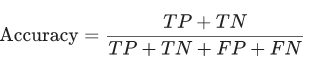

Thus, the accuracy is the number of correct predictions divided by the total of the number of predictions.

In [106]:
# The metric accuracy from keras
accuracy = tf.keras.metrics.Accuracy()

In [107]:
# Results are stored in a disct
accuracy_per_class = {}

# Accuracy is calculated for each class
for col in range(y_pred.shape[1]):
    col_pred = y_pred[:,col]
    col_true = y_true[:,col]
    class_name = class_names[col]
    accuracy.update_state(col_true, col_pred)
    accuracy_per_class[class_name] = accuracy.result().numpy()

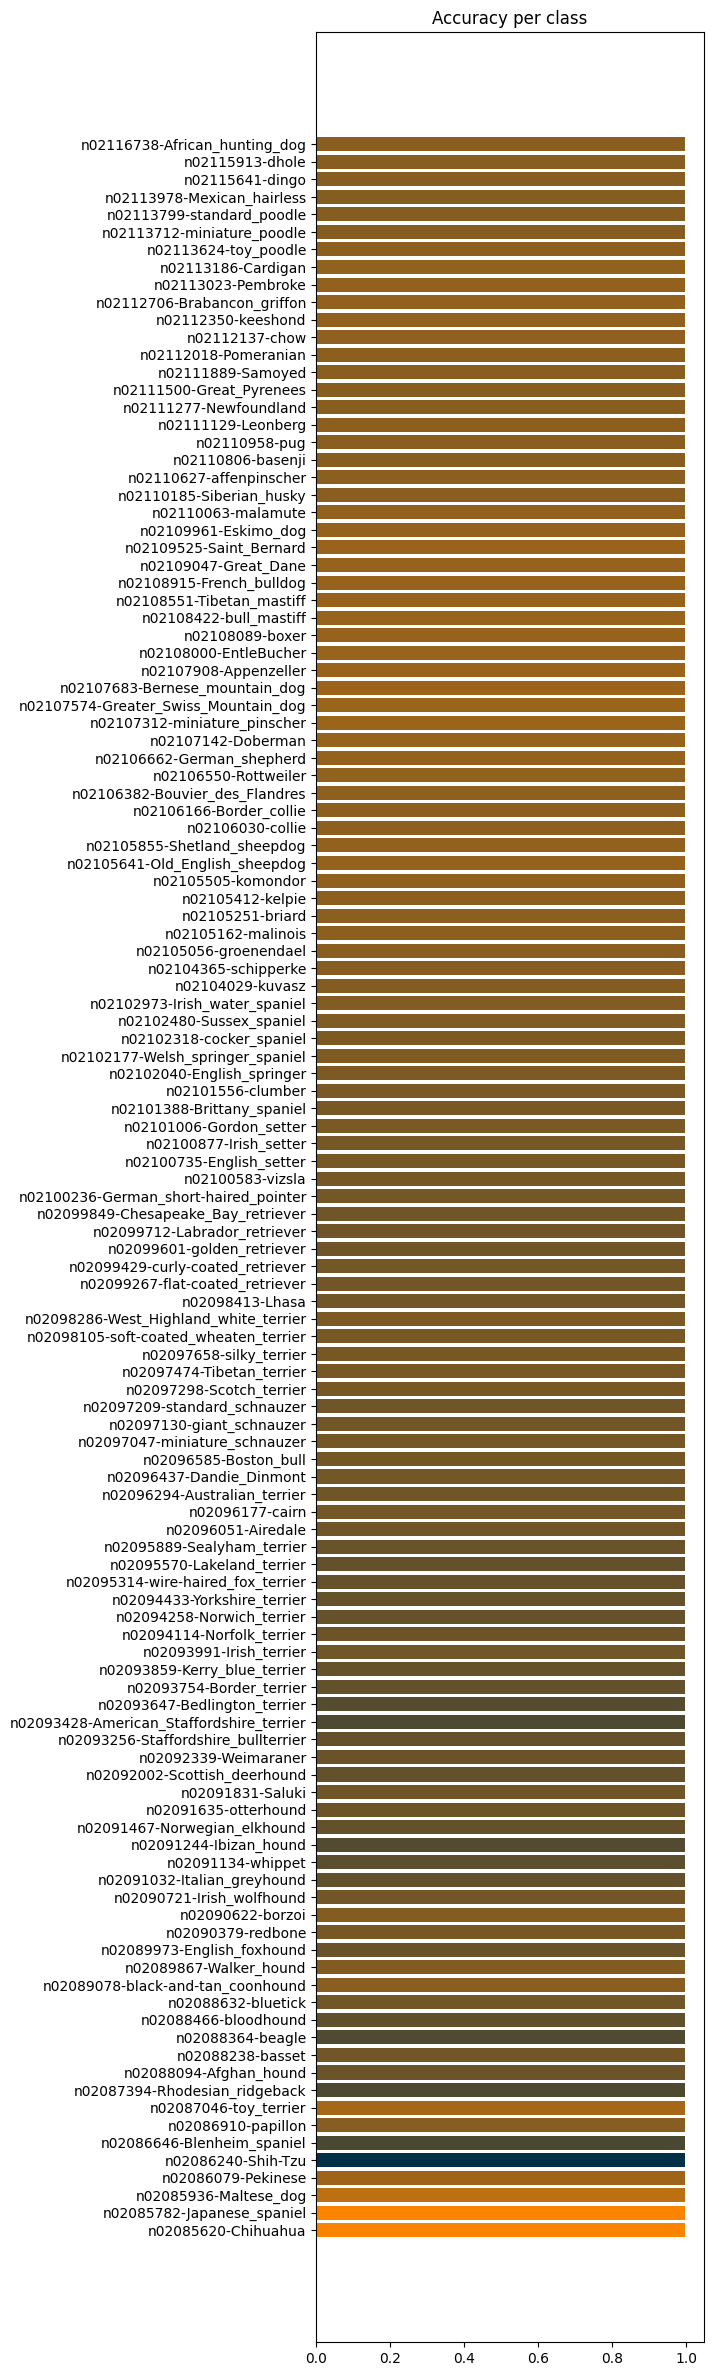

In [108]:
fig, ax = plt.subplots(figsize=(5,30))

ax.barh(y = list(accuracy_per_class.keys()),
        width = accuracy_per_class.values(),
        color= color_bar(list(accuracy_per_class.values())))

ax.set_title('Accuracy per class')
plt.show()

When measuring the accuracy of the model class per class, it appears that all classes show a high accuracy (around 98%). However, accuracy takes into account the true negatives (0 values) which are predominant in the dataset (as the set results form one-hot encoded categories). Other metrics as precision and recall could better characterize the model performances.

## 6.2 Precision and recall

### 6.2.1 Precison

The precision is measuring the proportion of correct predictions among the positive prediction **only**. It is measured with the following equation :

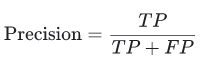

In our case, it indicates for a given breed the proprotion that have been attributed falsely to dogs from other breeds.

In [109]:
# The metric precision from keras
precision = tf.keras.metrics.Precision()

# Results are stored in a disct
precision_per_class = {}

# Accuracy is calculated for each class
for col in range(y_pred.shape[1]):
    col_pred = y_pred[:,col]
    col_true = y_true[:,col]
    class_name = class_names[col]
    precision.update_state(col_true, col_pred)
    precision_per_class[class_name] = precision.result().numpy()

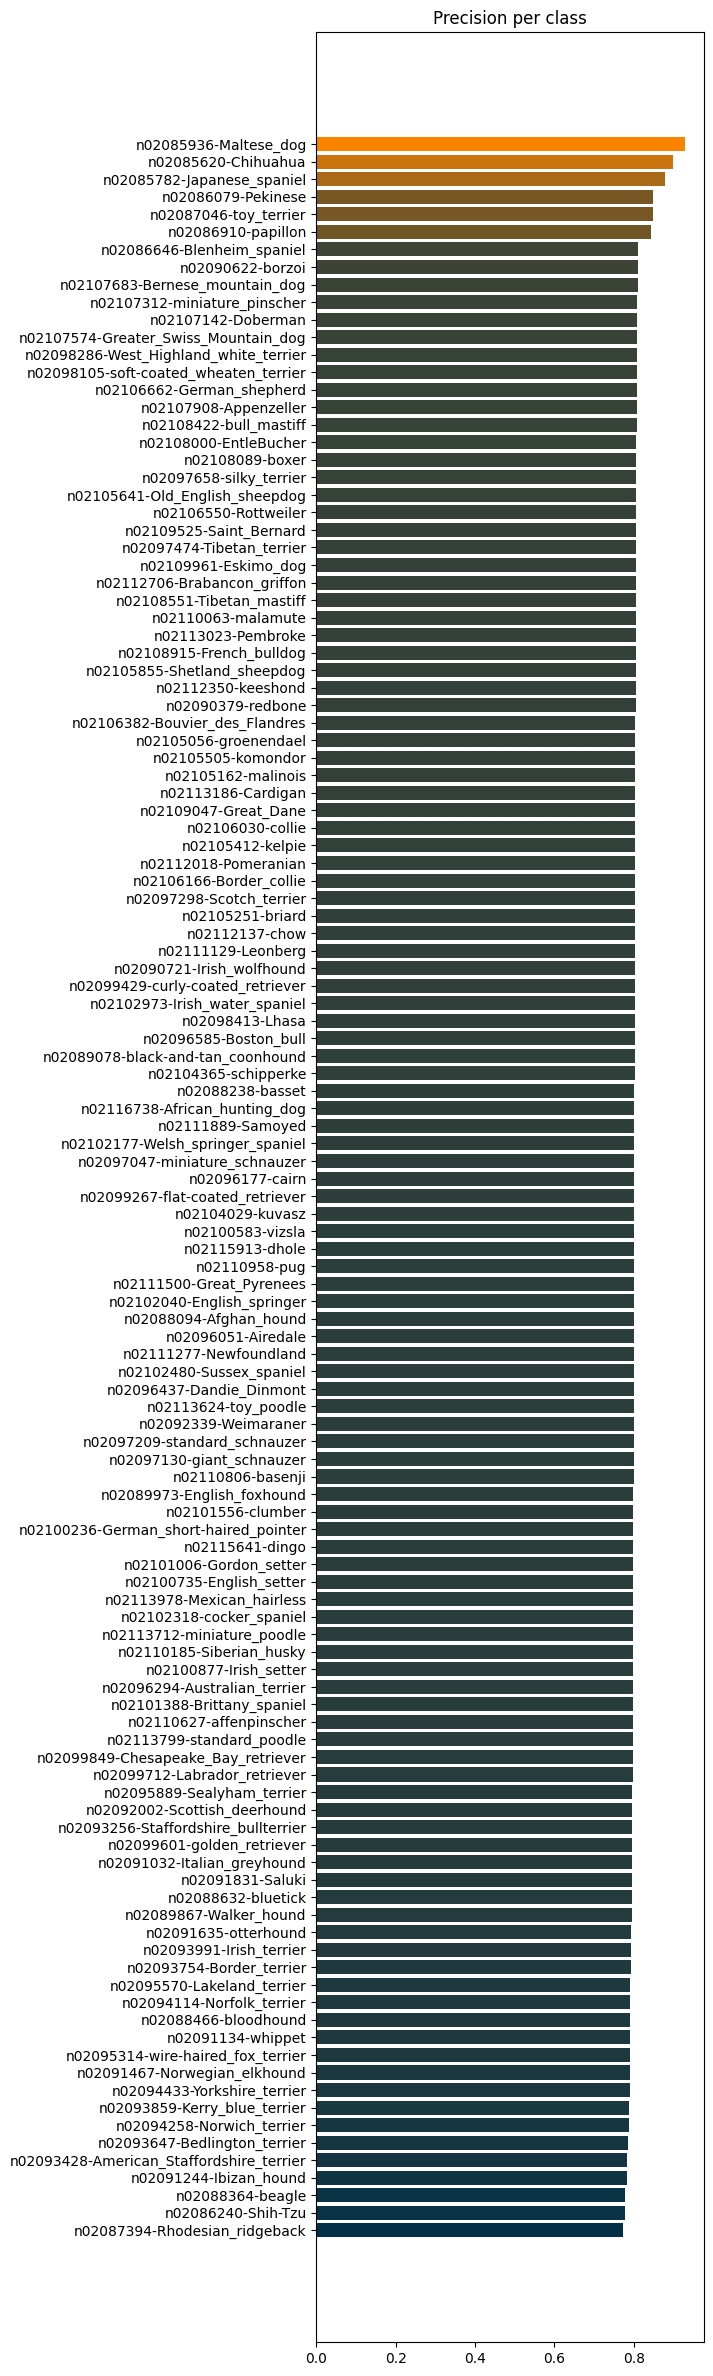

In [111]:
# Values are sorted for a better readability


names = np.take_along_axis(np.array(list(precision_per_class.keys())),
                           np.argsort(np.array(list(precision_per_class.values()))),
                           axis = 0)

values = np.sort(np.array(list(precision_per_class.values())))


fig, ax = plt.subplots(figsize=(5,30))

ax.barh(y = names,
        width = values,
        color= color_bar(values))

ax.set_title('Precision per class')
plt.show()

The Rhodesian_ridgeback cerresponds to the class where the proportion of correct positive predictions is the lowest. Its index in the class_names is looked at:

In [114]:
# Finding the index of the class with the lower precision
class_names.index('n02087394-Rhodesian_ridgeback')

8

From this index, it is possible to display all samples that were falsely attributed to Rhodesian_ridgeback and the corresponding real breed.

In [129]:
pred_list = []
for index, value in np.ndenumerate(y_pred[:,8]):
    if value==1 and y_true[index,8] != 1:
        pred_list.append(y_true[index,:].argmax())

In [130]:
pred_list

[91, 17, 60, 95, 57, 60, 29, 74, 101, 29, 76, 17, 74, 25, 27, 12, 17, 34]

The breed with the index 17 seems to be the one that is the most mistaken with Rhodesian_ridgeback

In [131]:
class_names[17]

'n02090379-redbone'

Indeed, both breed show physical similarities :

**Rhodesian_ridgeback**

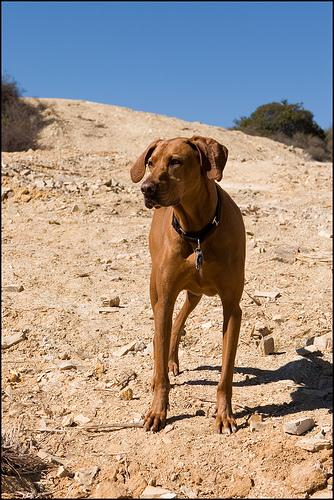

**Redbone**

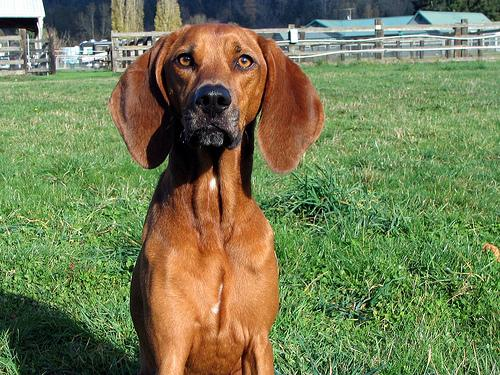

### 6.2.2 Recall

Recall is a metric that indicates the proportion of true positives that were was identified correctly. It is calculated with the following equation :

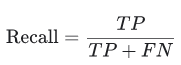

In our case, it indicates for a given breed what is the porportion of other breeds that are falsely attributed by the model to picture of dogs of the first breed. 

In [132]:
# The metric precision from keras
recall = tf.keras.metrics.Recall()

# Results are stored in a disct
recall_per_class = {}

# Accuracy is calculated for each class
for col in range(y_pred.shape[1]):
    col_pred = y_pred[:,col]
    col_true = y_true[:,col]
    class_name = class_names[col]
    recall.update_state(col_true, col_pred)
    recall_per_class[class_name] = recall.result().numpy()

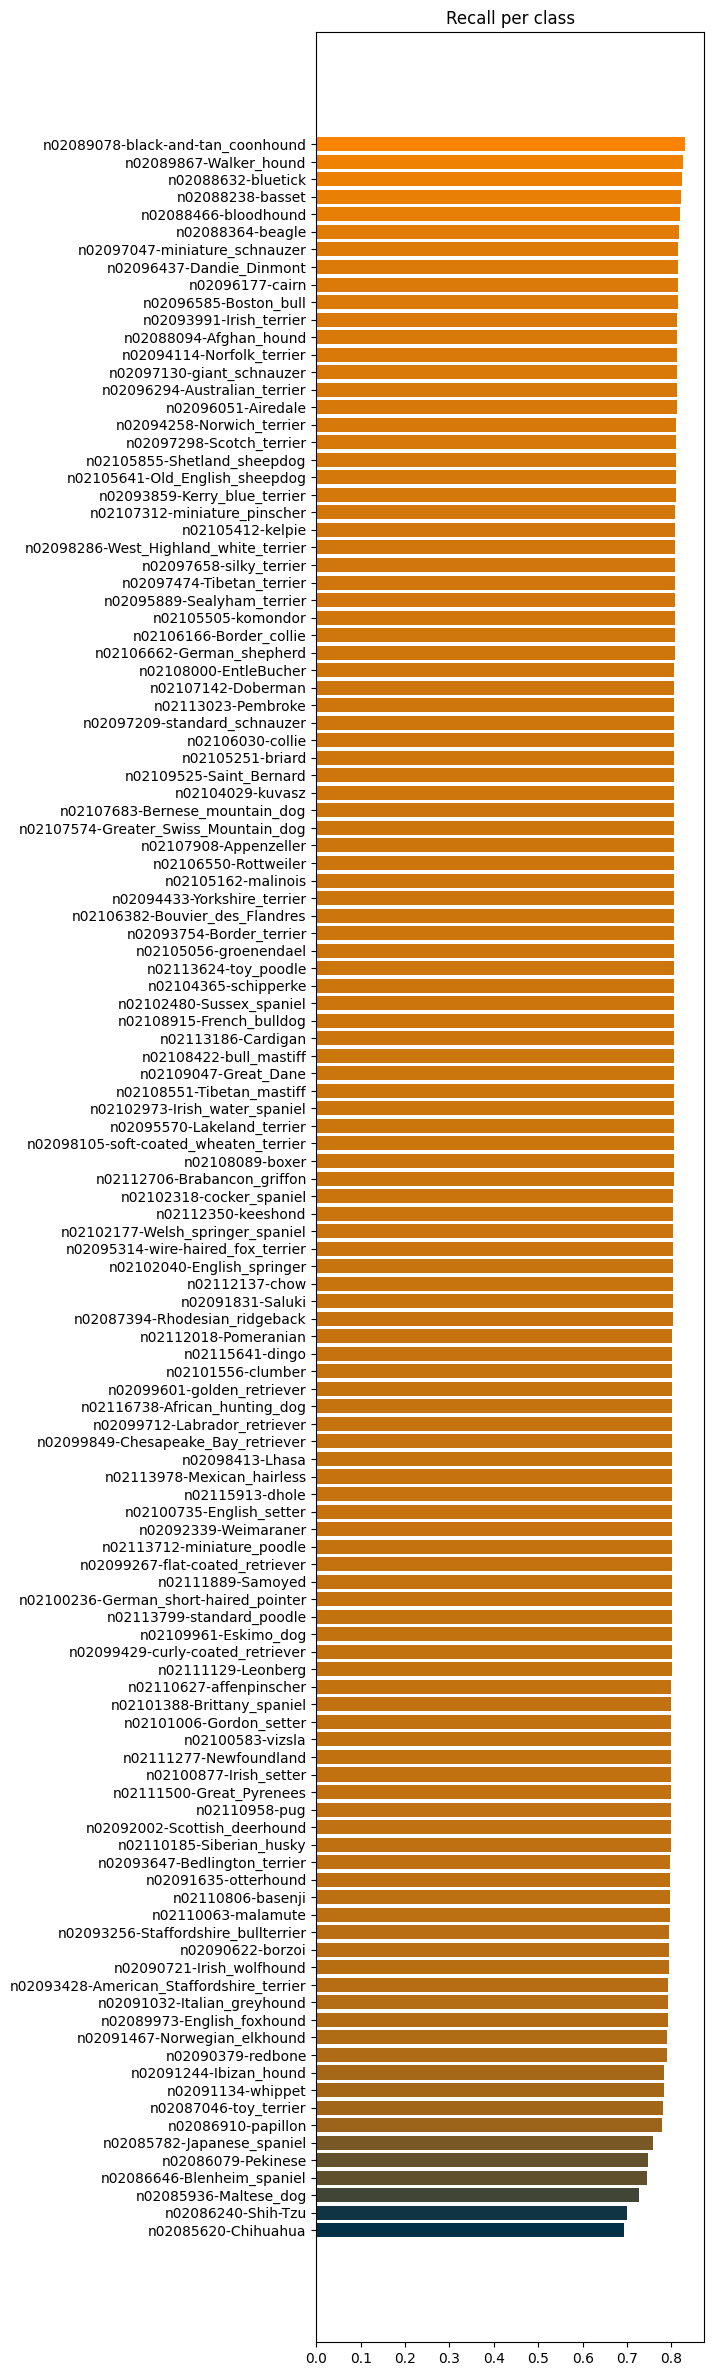

In [133]:
# Values are sorted for a better readability


names = np.take_along_axis(np.array(list(recall_per_class.keys())),
                           np.argsort(np.array(list(recall_per_class.values()))),
                           axis = 0)

values = np.sort(np.array(list(recall_per_class.values())))


fig, ax = plt.subplots(figsize=(5,30))

ax.barh(y = names,
        width = values,
        color= color_bar(values))

ax.set_title('Recall per class')
plt.show()

The Chihuahua cerresponds to the class where the proportion of correct positive predictions is the lowest. Its index in the class_names is looked at:

In [134]:
# Finding the index of the class with the lower precision
class_names.index('n02085620-Chihuahua')

0

From this index, it is possible to display all samples that were falsely attributed something else than to Chihuahua and the corresponding predicted breed.

In [137]:
pred_list = []
for index, value in np.ndenumerate(y_true[:,0]):
    if value==1 and y_pred[index,0] != 1:
        pred_list.append(y_pred[index,:].argmax())

In [138]:
pred_list

[112, 110, 22, 61]

In [22]:
for index in pred_list:
    print(class_names[index])

n02113186-Cardigan
n02112706-Brabancon_griffon
n02091244-Ibizan_hound
n02100735-English_setter


The breeds flasely attributed to Chihuahuas are :

**Cardigan**

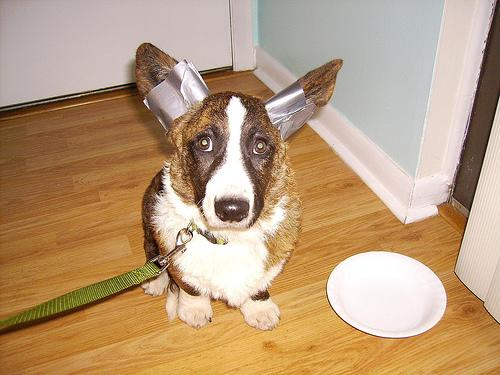


**Brabancon_griffon**

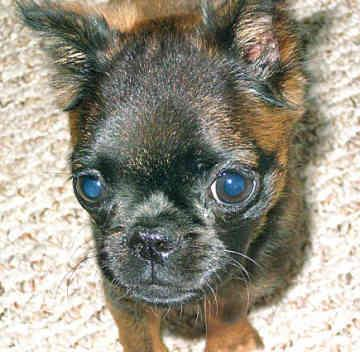


**Ibizan_hound**

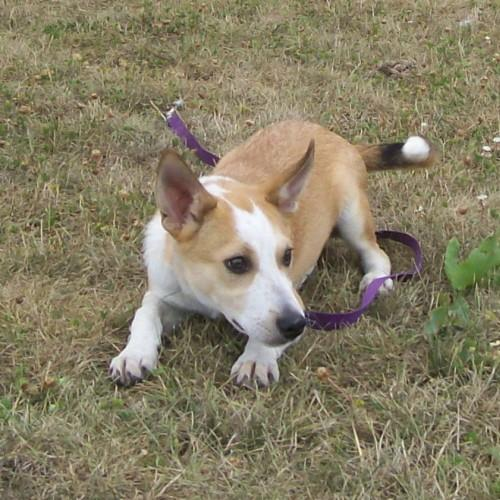


**English_setter**

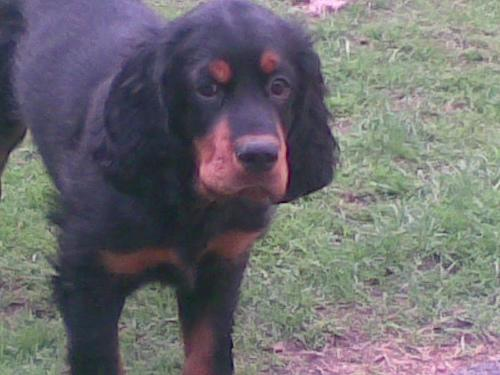

The confusion of the model with these breeds is more mysterious and could be investigated further.

# 7. Conclusion

The aim of this project was to explore the use of images as input for the training of deep neural networks. For this, a dataset containing 20 508 images of dogs of 120 different breeds have been collected.

First an exploratory data analysis has been performed. From this study, it appeared that the dog breeds were represented by an unequal but balanced number of pictures with an average of 171 pictures and a standard deviation of 23. A rapid look randomly drawn picture indicated that the pictures could present multiple dogs, their owner and possibly a complex background, making the classification evermore difficult. Finally, the picture definition has been studied. The pictures present a large range of dimensions between 0.4 and 0.8 Mpixels. Moreover certain dog breeds the Saint Bernard or Irish water spaniel are represented by pictures with, on an average, a higher definition.

During this project, the images have been imported following two strategies. First data have been imported with the tool "image_dataset_from_directory" from keras. This tool allows to rapidly create an efficient dataset with the images directories. Then, a second method starting from ".Dataset.from_tensor_slices" and building the dataset "by hand" was also assessed. This method was more complex but allowed to add a parameter for choosing a list of breeds to be imported in the dataset.

After that the data were imported, several methods of images preprocessing have been studied. Such methods can amplify features in the images for allowing faster processing. Functions have been built for pixel value centering, ZCA whitening, equalization and contour detection. The superimposition of methods have also been essayed.

Then a model of deep learning inspired by the popular model VGG16 has been built from scratch. After assessing the model performances, it has been found that the model was largely overfitting. Adding dropout and augmentation layers allowed to reduce the overfitting but the model showed poor performances.

Lower the number of targets (from 120 to 10 and then to 2) had a significant impact on the model performances and learning rate. The simple model built from scratch showed the better performances for a binary classification.

Techniques of transfer learning have then been assayed. Three popular models have been tested: VGG16, ResNet50V2 and Xception. When training only the final dense layers, VGG16 showed good performances (val accuracy = 0.53) but the high performances were obtained with Xception (val accuracy = 0.80). In the contrary ResNet50 showed poor performances, possibly indicating the high specificity of the model.

Train the first and last layers of VGG16 and ResNet50 was essayed. This methodology allows adapting the first layers of the model to the data considered in our project. Training the first layers of ResNet50 greatly improved the model performances. Inversely, VGG16 showed poor performances when train the first layers, showing that this method should be used on a case-by-case basis.

Finally, the productions of the model showing the higher performances were studied in detail with appropriates metrics. When metrics were applied on a specific class, Precision and Recall showed interesting trends and allowed to better understand the in-depth working of the model. As an example the dogs that were the most mistaken indeed showed physical similarities.